# Comparison of the screen results
---

This notebook evaluates the results of the specificity screen. In particular, it compares the performance of a linear classifier trained on the morphological profiles from Rohban et al(2017), a single ResNet18 trained on the single-cell chromatin images and our proposed ResNet ensemble trained on both single-cell and region chromatin images.

## 0. Environmental setup

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import venn
from typing import List
from umap import UMAP
import os
from scipy.stats import pearsonr
from kneed import KneeLocator
from loess import loess_1d
from scipy.stats import fisher_exact, ranksums, ttest_1samp
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

from statannot import add_stat_annotation

import sys

sys.path.append("../../../../")

from src.utils.basic.io import get_file_list
from src.utils.notebooks.images.exp_evaluation import *

mpl.rcParams["figure.dpi"] = 600


%autosave 60

Autosaving every 60 seconds


In [2]:
cell_cycle_genes = set(
    pd.read_csv(
        "../../../../data/resources/genesets/reactome_cell_cycle.txt",
        index_col=0,
        header=None,
    ).index
)
chrom_org_genes = set(
    pd.read_csv(
        "../../../../data/resources/genesets/reactome_chrom_org.txt",
        index_col=0,
        header=None,
    ).index
)
dna_repair_genes = set(
    pd.read_csv(
        "../../../../data/resources/genesets/reactome_dna_repair.txt",
        index_col=0,
        header=None,
    ).index
)
reg_actin_cytoskeleton_genes = set(
    pd.read_csv(
        "../../../../data/resources/genesets/kegg_reg_act_cytoskeleton.txt",
        index_col=0,
        header=None,
    ).index
)
human_tfs = set(
    list(
        pd.read_csv(
            "../../../../data/resources/genesets/human_tf_list.txt",
            index_col=0,
            header=None,
        ).index
    )
)
toxic_genes = {
    "ATF4",
    "ATF6",
    "BCL2L11",
    "CASP8",
    "CEBPA",
    "CXXC4",
    "ELK1",
    "ERG",
    "JUN",
    "NOTCH2",
    "PRKACA",
    "RHOA",
    "XBP1",
}
curated_gene_sets = (
    cell_cycle_genes.union(chrom_org_genes)
    .union(dna_repair_genes)
    .union(reg_actin_cytoskeleton_genes)
    .union(human_tfs)
)

In [3]:
rohban_target_set = pd.read_csv(
    "../../../../data/resources/target_lists/rhoban_specific_orf_targets.csv",
    index_col=0,
)
rohban_targets = set(rohban_target_set.index)

---

## 1. Read in data

First, we will read in the data which automatically scans the given directories of the individual screens for the corresponding log-files and extract the different scores from those.

### 1.1. Morphological profiles screen

In [4]:
morph_results_fold_0 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/morph_profiles/screen/fold_0"
)
morph_results_fold_1 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/morph_profiles/screen/fold_1"
 )
morph_results_fold_2 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/morph_profiles/screen/fold_2"
)
morph_results_fold_3 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/morph_profiles/screen/fold_3"
)

morph_results_fold_0.index = np.array(morph_results_fold_0.target)
morph_results_fold_1.index = np.array(morph_results_fold_1.target)
morph_results_fold_2.index = np.array(morph_results_fold_2.target)
morph_results_fold_3.index = np.array(morph_results_fold_3.target)

morph_results = (
    morph_results_fold_0.append(morph_results_fold_1)
    .append(morph_results_fold_2)
    .append(morph_results_fold_3)
)

<ipython-input-4-44d98899df38>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  morph_results_fold_0.append(morph_results_fold_1)
<ipython-input-4-44d98899df38>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  morph_results_fold_0.append(morph_results_fold_1)
<ipython-input-4-44d98899df38>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  morph_results_fold_0.append(morph_results_fold_1)


---

### 1.2. Single-nuclei image screen

In [5]:
nuclei_results_fold_0 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/nuclei/fold_0"
)
nuclei_results_fold_1 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/nuclei/fold_1"
)
nuclei_results_fold_2 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/nuclei/fold_2"
)
nuclei_results_fold_3 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/nuclei/fold_3"
)

nuclei_results_fold_0.index = np.array(nuclei_results_fold_0.target)
nuclei_results_fold_1.index = np.array(nuclei_results_fold_1.target)
nuclei_results_fold_2.index = np.array(nuclei_results_fold_2.target)
nuclei_results_fold_3.index = np.array(nuclei_results_fold_3.target)

nuclei_results = (
    nuclei_results_fold_0.append(nuclei_results_fold_1)
    .append(nuclei_results_fold_2)
    .append(nuclei_results_fold_3)
)

<ipython-input-5-a169642b9ba0>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuclei_results_fold_0.append(nuclei_results_fold_1)
<ipython-input-5-a169642b9ba0>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuclei_results_fold_0.append(nuclei_results_fold_1)
<ipython-input-5-a169642b9ba0>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nuclei_results_fold_0.append(nuclei_results_fold_1)


---

### 1.3. Nuclei + region image screen

In [6]:
multi_results_fold_0 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/nuclei_region/fold_0"
)
multi_results_fold_1 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/nuclei_region/fold_1"
)
multi_results_fold_2 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/nuclei_region/fold_2"
)
multi_results_fold_3 = analyze_screen_results(
    "../../../../data/experiments/rohban/images/screen/nuclei_region/fold_3"
)

multi_results_fold_0.index = np.array(multi_results_fold_0.target)
multi_results_fold_1.index = np.array(multi_results_fold_1.target)
multi_results_fold_2.index = np.array(multi_results_fold_2.target)
multi_results_fold_3.index = np.array(multi_results_fold_3.target)

multi_results = (
    multi_results_fold_0.append(multi_results_fold_1)
    .append(multi_results_fold_2)
    .append(multi_results_fold_3)
)

<ipython-input-6-1fc2f672af78>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  multi_results_fold_0.append(multi_results_fold_1)
<ipython-input-6-1fc2f672af78>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  multi_results_fold_0.append(multi_results_fold_1)
<ipython-input-6-1fc2f672af78>:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  multi_results_fold_0.append(multi_results_fold_1)


---

## 2. Analyses

### 2.1. Exploratory analyses

After having read in the data, we will first compute specificity score for each target which is given by the mean cross-validated balanced accuracy for each target. We will plot the corresponding scores as a bar plot for each of the compared model setups. The standard deviations will be shown by the error bars. The scores will be ordered in decreasing fashion.

#### 2.1.1. Morphological profiles

In [7]:
morph_order = list(
    morph_results.groupby("target")
    .mean()
    .sort_values("test_bacc", ascending=False)
    .index
)

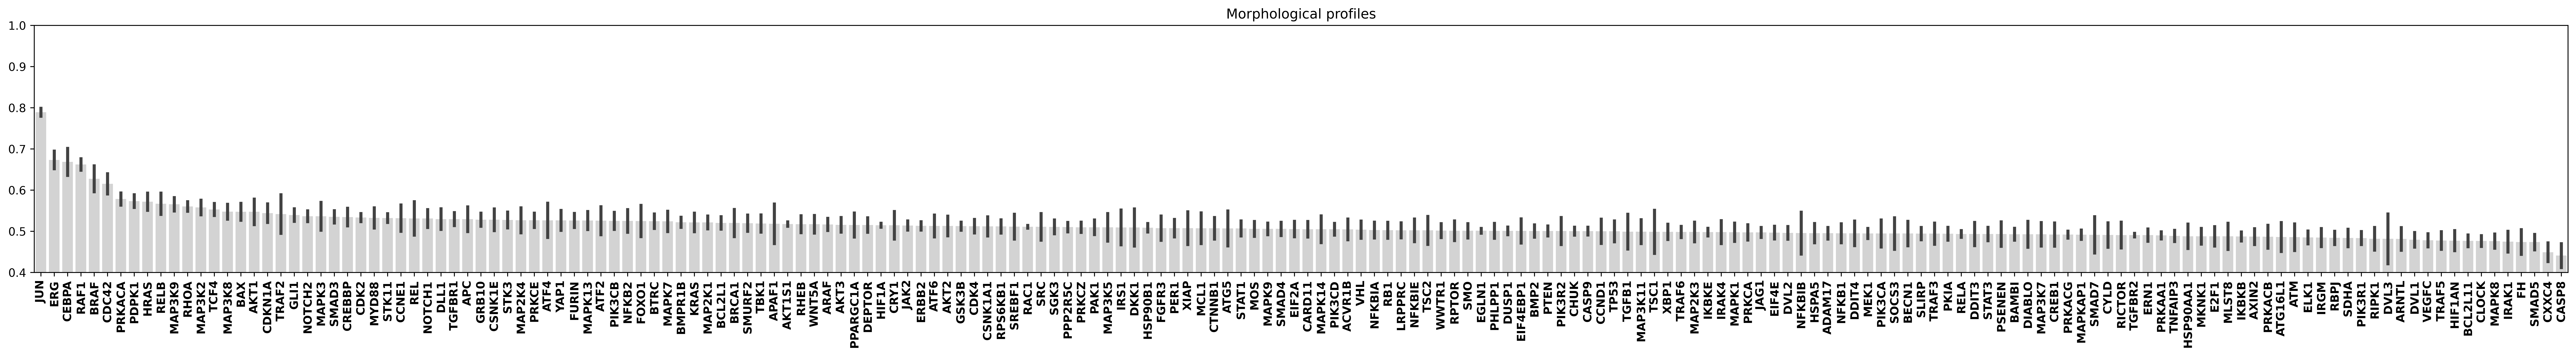

In [8]:
fig, ax = plt.subplots(figsize=[40, 4])
ax = sns.barplot(
    data=morph_results.loc[morph_results.target.isin(morph_order)],
    x="target",
    y="test_bacc",
    ci="sd",
    order=morph_order,
    color="lightgray",
    ax=ax,
    #     capsize=0.2,
)
ax.set_ylim([0.4, 1])
ax.set_xticklabels(morph_order, rotation=90, fontsize=10, fontweight="bold")
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Morphological profiles")
plt.show()

---

#### 2.1.2 Nuclei image screen

In [9]:
nuclei_order = list(
    nuclei_results.groupby("target")
    .mean()
    .sort_values("test_bacc", ascending=False)
    .index
)

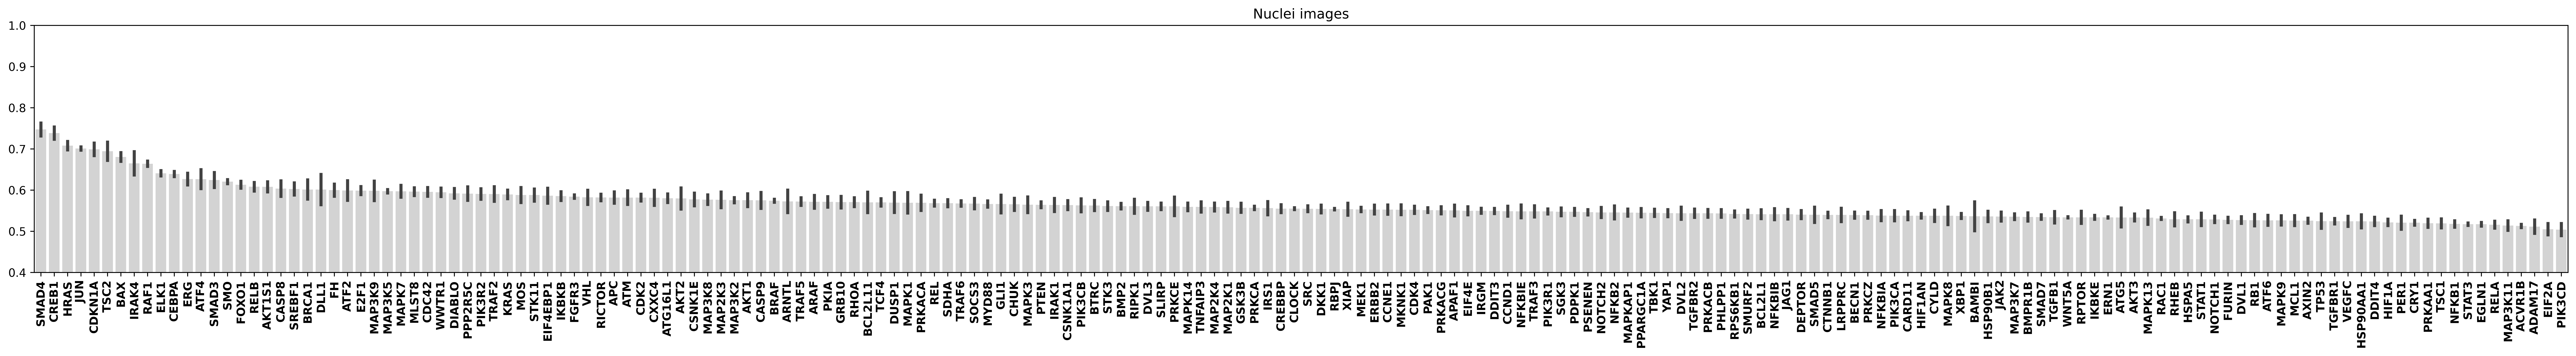

In [10]:
fig, ax = plt.subplots(figsize=[40, 4])
ax = sns.barplot(
    data=nuclei_results.loc[nuclei_results.target.isin(nuclei_order)],
    x="target",
    y="test_bacc",
    ci="sd",
    order=nuclei_order,
    color="lightgray",
    ax=ax,
    #     capsize=0.2,
)
ax.set_ylim([0.4, 1])
ax.set_xticklabels(nuclei_order, rotation=90, fontsize=10, fontweight="bold")
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Nuclei images")
plt.show()

---

#### 2.1.3. Nuclei + region image screen

In [11]:
multi_order = list(
    multi_results.groupby("target")
    .mean()
    .sort_values("test_bacc", ascending=False)
    .index
)

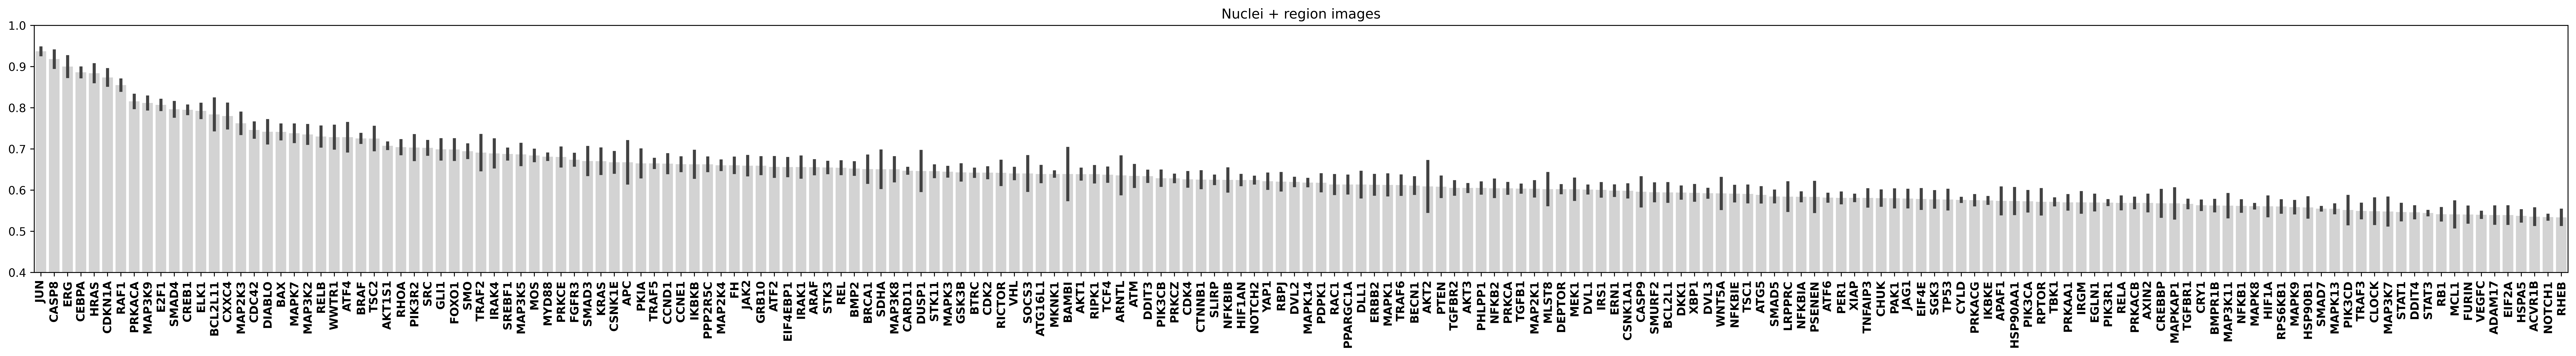

In [12]:
fig, ax = plt.subplots(figsize=[40, 4])
ax = sns.barplot(
    data=multi_results.loc[multi_results.target.isin(multi_order)],
    x="target",
    y="test_bacc",
    ci="sd",
    order=multi_order,
    color="lightgray",
    ax=ax,
    #     capsize=0.2,
)
ax.set_ylim([0.4, 1])
ax.set_xticklabels(multi_order, rotation=90, fontsize=10, fontweight="bold")
ax.set_ylabel("")
ax.set_xlabel("")
ax.set_title("Nuclei + region images")
plt.show()

---

### 2.2. Comparison of the results

We will now compare the results of the individual screens to assess which inputs yield better representations that separate the perturbed from the control cells and thus provide more sensitive read-outs of the chromatin organization in the perturbation settings.

#### 2.2.1. Morphological profiles vs. single-nuclei images

First, we will compare the morphological profiles to the representations extracted by the ResNet18 from the single-nuclei inputs. Both representation describe single-cells but the morphological profiles also contain some information regarding the cell density.

As a first step we will look at the distribution of the differences of the specificity scores given by the four-fold cross-validated balanced accuracy for those two models.

In [13]:
avg_morph_results = morph_results.groupby("target").mean()
avg_nuclei_results = nuclei_results.groupby("target").mean()

nuclei_minus_morph_results = avg_nuclei_results - avg_morph_results
nuclei_minus_morph_results.describe()

train_loss    val_loss   test_loss   train_acc     val_acc    test_acc  \
count  190.000000  190.000000  190.000000  190.000000  190.000000  190.000000   
mean    -0.130458   -0.036591   -0.045395    0.131954    0.050373    0.050815   
std      0.059824    0.045494    0.040745    0.059630    0.050650    0.043304   
min     -0.337242   -0.326069   -0.228278   -0.034162   -0.078949   -0.088297   
25%     -0.158346   -0.057741   -0.064051    0.093909    0.022314    0.024963   
50%     -0.124856   -0.037646   -0.043405    0.129003    0.047246    0.044161   
75%     -0.090290   -0.012758   -0.023349    0.165840    0.070067    0.070322   
max      0.021289    0.105744    0.110036    0.318878    0.356255    0.245815   

       train_bacc    val_bacc   test_bacc  
count  190.000000  190.000000  190.000000  
mean     0.132059    0.051595    0.051236  
std      0.059797    0.052702    0.043505  
min     -0.033988   -0.089667   -0.088201  
25%      0.093698    0.021651    0.025425  
50%      0.128683    0.044157    0.044395  
75%      0.164928    0.071228    0.071674  
max      0.320135    0.360899    0.246330

t-test for zero-mean Ttest_1sampResult(statistic=16.23353169496188, pvalue=5.56011642842951e-38)


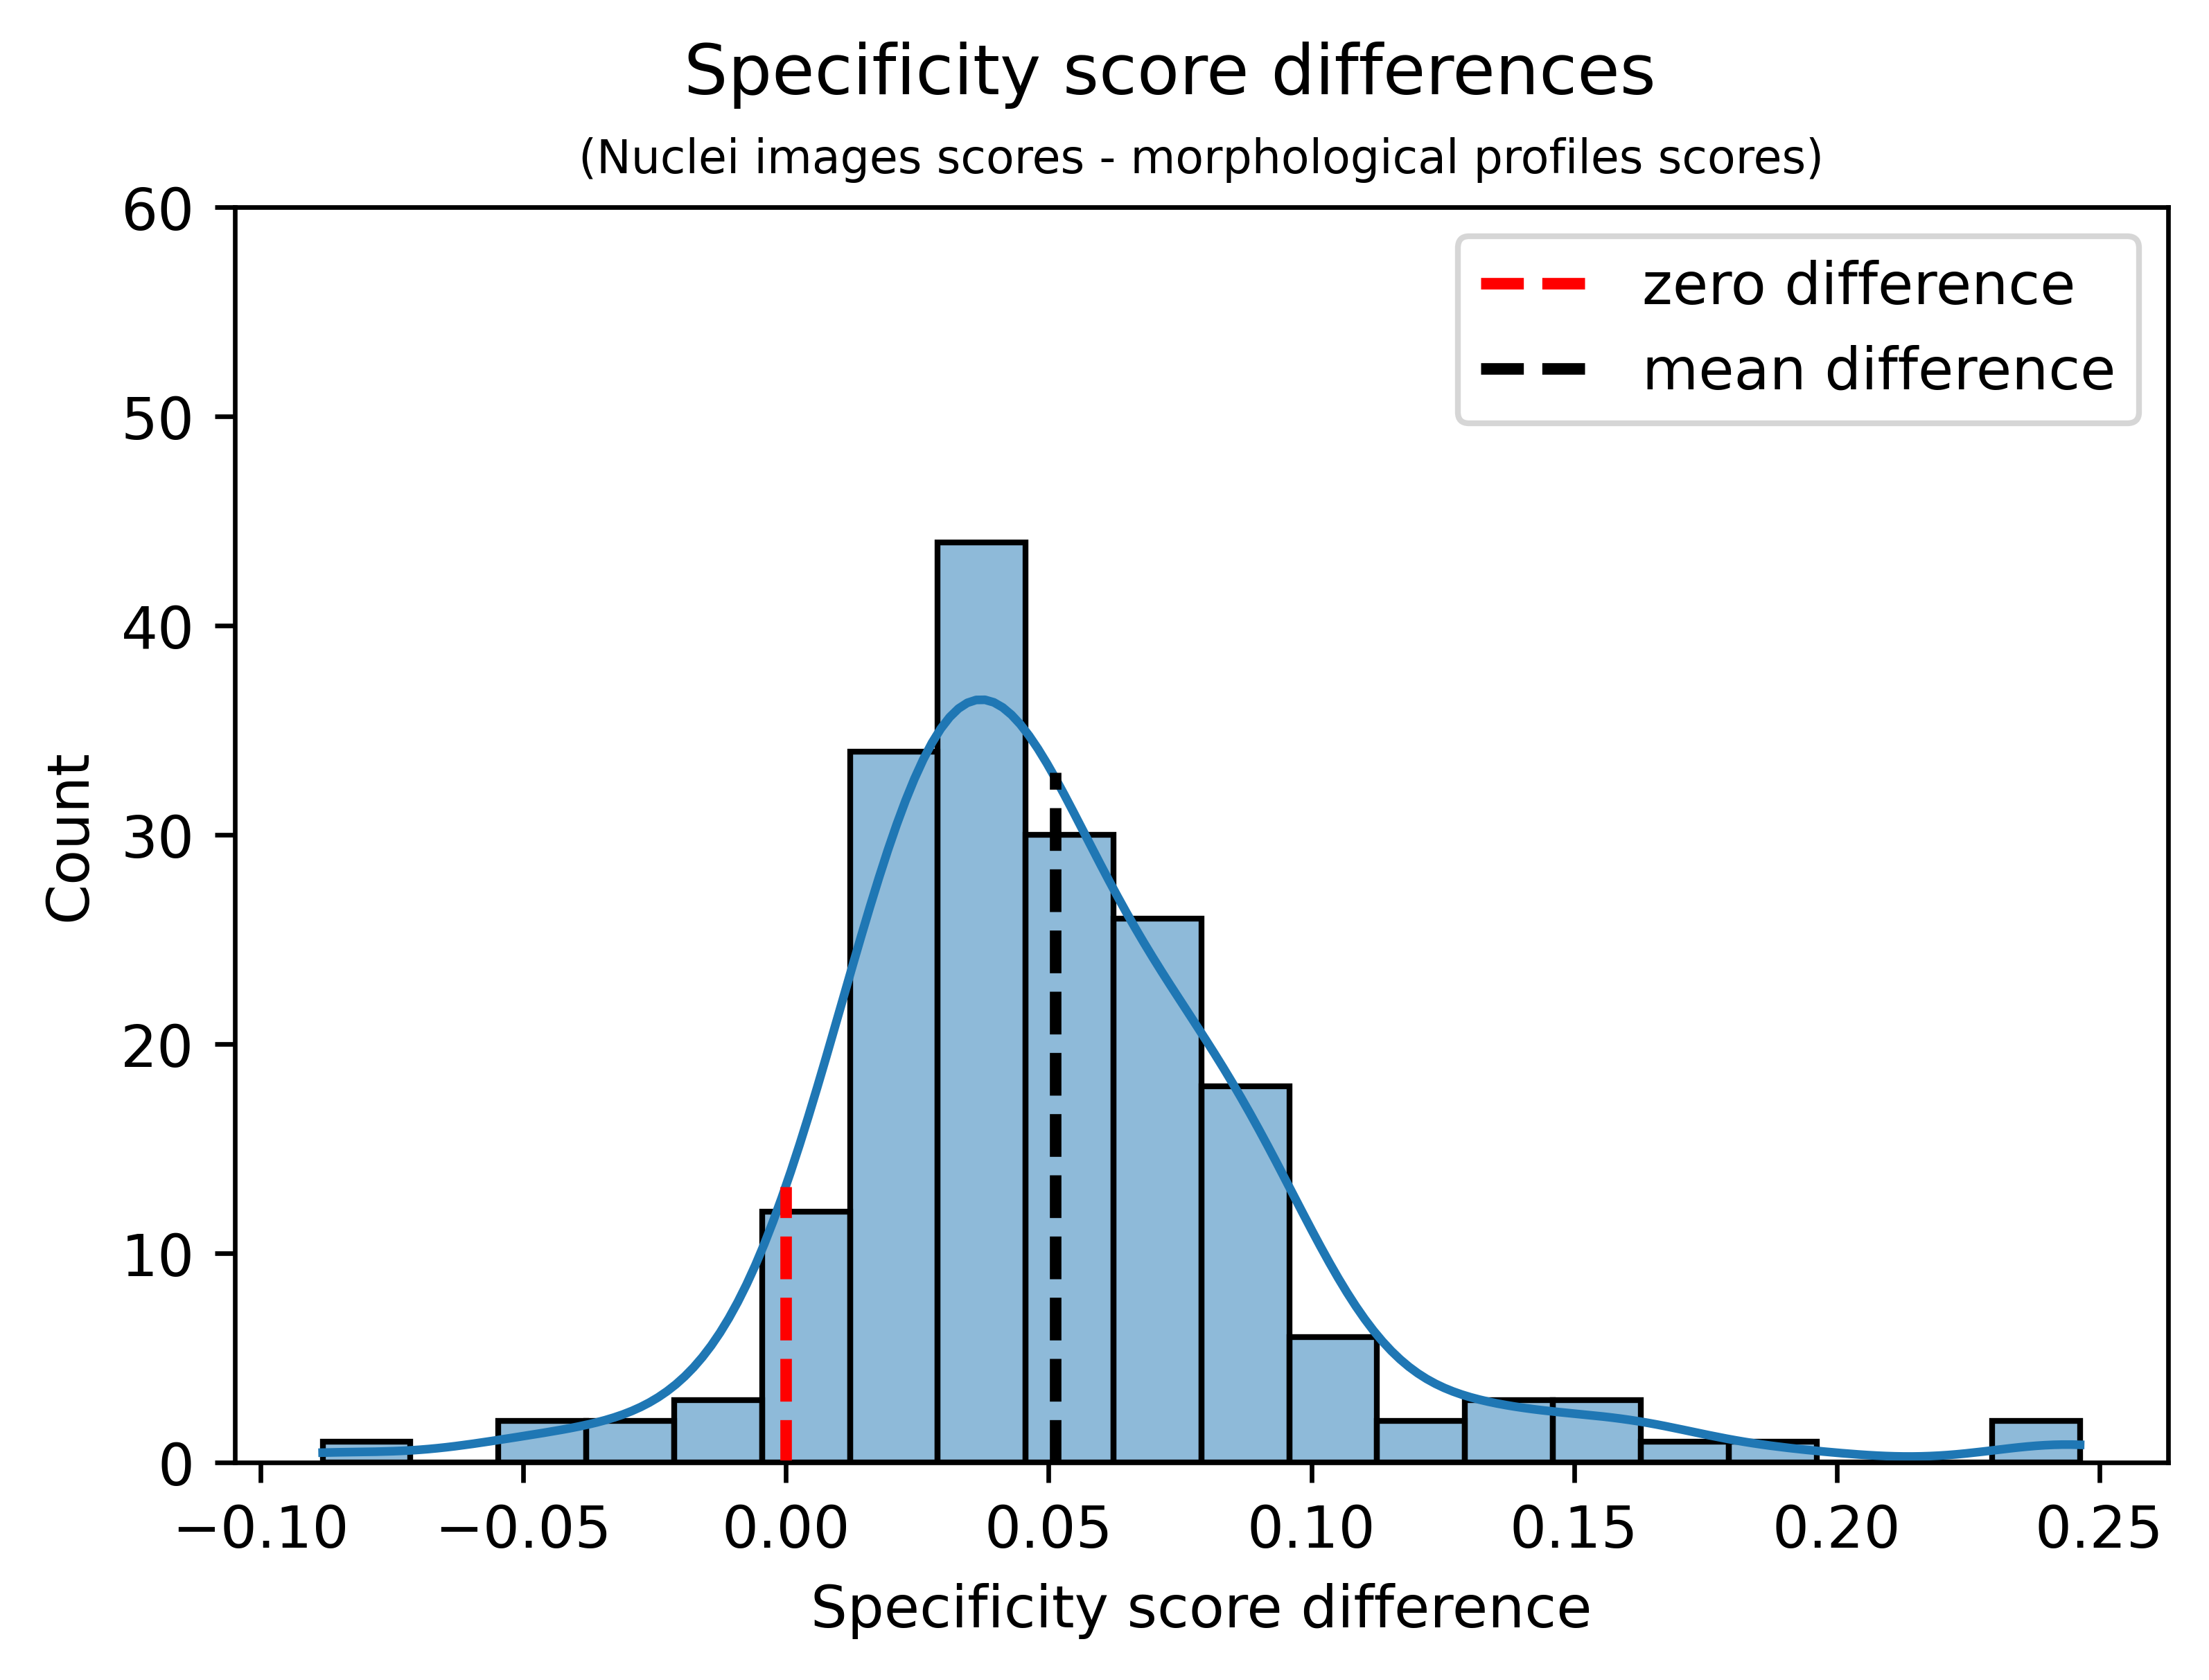

In [14]:
print("t-test for zero-mean", ttest_1samp(np.array(nuclei_minus_morph_results.test_bacc), popmean=0, alternative="greater"))

fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.histplot(
    data=nuclei_minus_morph_results, x="test_bacc", kde=True, bins=20, alpha=0.5
)
# ax.set_xlim([-0.3, 0.3])
ax.axvline(x=0, linestyle="--", linewidth=2, color="red", ymax=0.22, label="zero difference")
ax.axvline(
    x=nuclei_minus_morph_results.test_bacc.mean(),
    linestyle="--",
    linewidth=2,
    color="k",
    ymax=0.55,
    label="mean difference"
)
ax.set_ylim([0, 60])
ax.set_xlabel("Specificity score difference")
ax.legend()
plt.xticks(np.arange(-0.1, 0.275, 0.05))
plt.suptitle("Specificity score differences")
plt.title("(Nuclei images scores - morphological profiles scores)", fontsize=8)
plt.show()


We see that the the computed specificity score for the single-nuclei image inputs is signficantly larger than the specificity scores obtained for the same targets using the moprhological profiles (p-value =5.56e-38, 1-sample t-test, H1: mean > 0). In fact, the specificity score of a given target obtained using the single nuclei image inputs is on average by 0.0512 (+/- 0.0435) larger than the respective specificity score for the same target obtained using the morphological profiles as input.


---

We next want to better understand for which type of targets the score differs. To this end, we compare the distribution of the specificity scores for the different inputs by binning the OE targets according to the mechano-transduction pathways mentioned above.

In [15]:
idx = nuclei_minus_morph_results.index

nuclei_minus_morph_results["Cell cycle"] = False
nuclei_minus_morph_results.loc[cell_cycle_genes.intersection(idx), "Cell cycle"] = True

nuclei_minus_morph_results["Chromatin organization"] = False
nuclei_minus_morph_results.loc[
    chrom_org_genes.intersection(idx), "Chromatin organization"
] = True

nuclei_minus_morph_results["DNA damage repair"] = False
nuclei_minus_morph_results.loc[
    dna_repair_genes.intersection(idx), "DNA damage repair"
] = True

nuclei_minus_morph_results["Actin cytoskeleton"] = False
nuclei_minus_morph_results.loc[
    reg_actin_cytoskeleton_genes.intersection(idx), "Actin cytoskeleton"
] = True

nuclei_minus_morph_results["Transcription factor"] = False
nuclei_minus_morph_results.loc[
    human_tfs.intersection(idx), "Transcription factor"
] = True

<ipython-input-15-e3f0a8f40be8>:4: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  nuclei_minus_morph_results.loc[cell_cycle_genes.intersection(idx), "Cell cycle"] = True
<ipython-input-15-e3f0a8f40be8>:7: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  nuclei_minus_morph_results.loc[
<ipython-input-15-e3f0a8f40be8>:12: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  nuclei_minus_morph_results.loc[
<ipython-input-15-e3f0a8f40be8>:17: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  nuclei_minus_morph_results.loc[
<ipython-input-15-e3f0a8f40be8>:22: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  nuclei_minus_morph_results.loc[


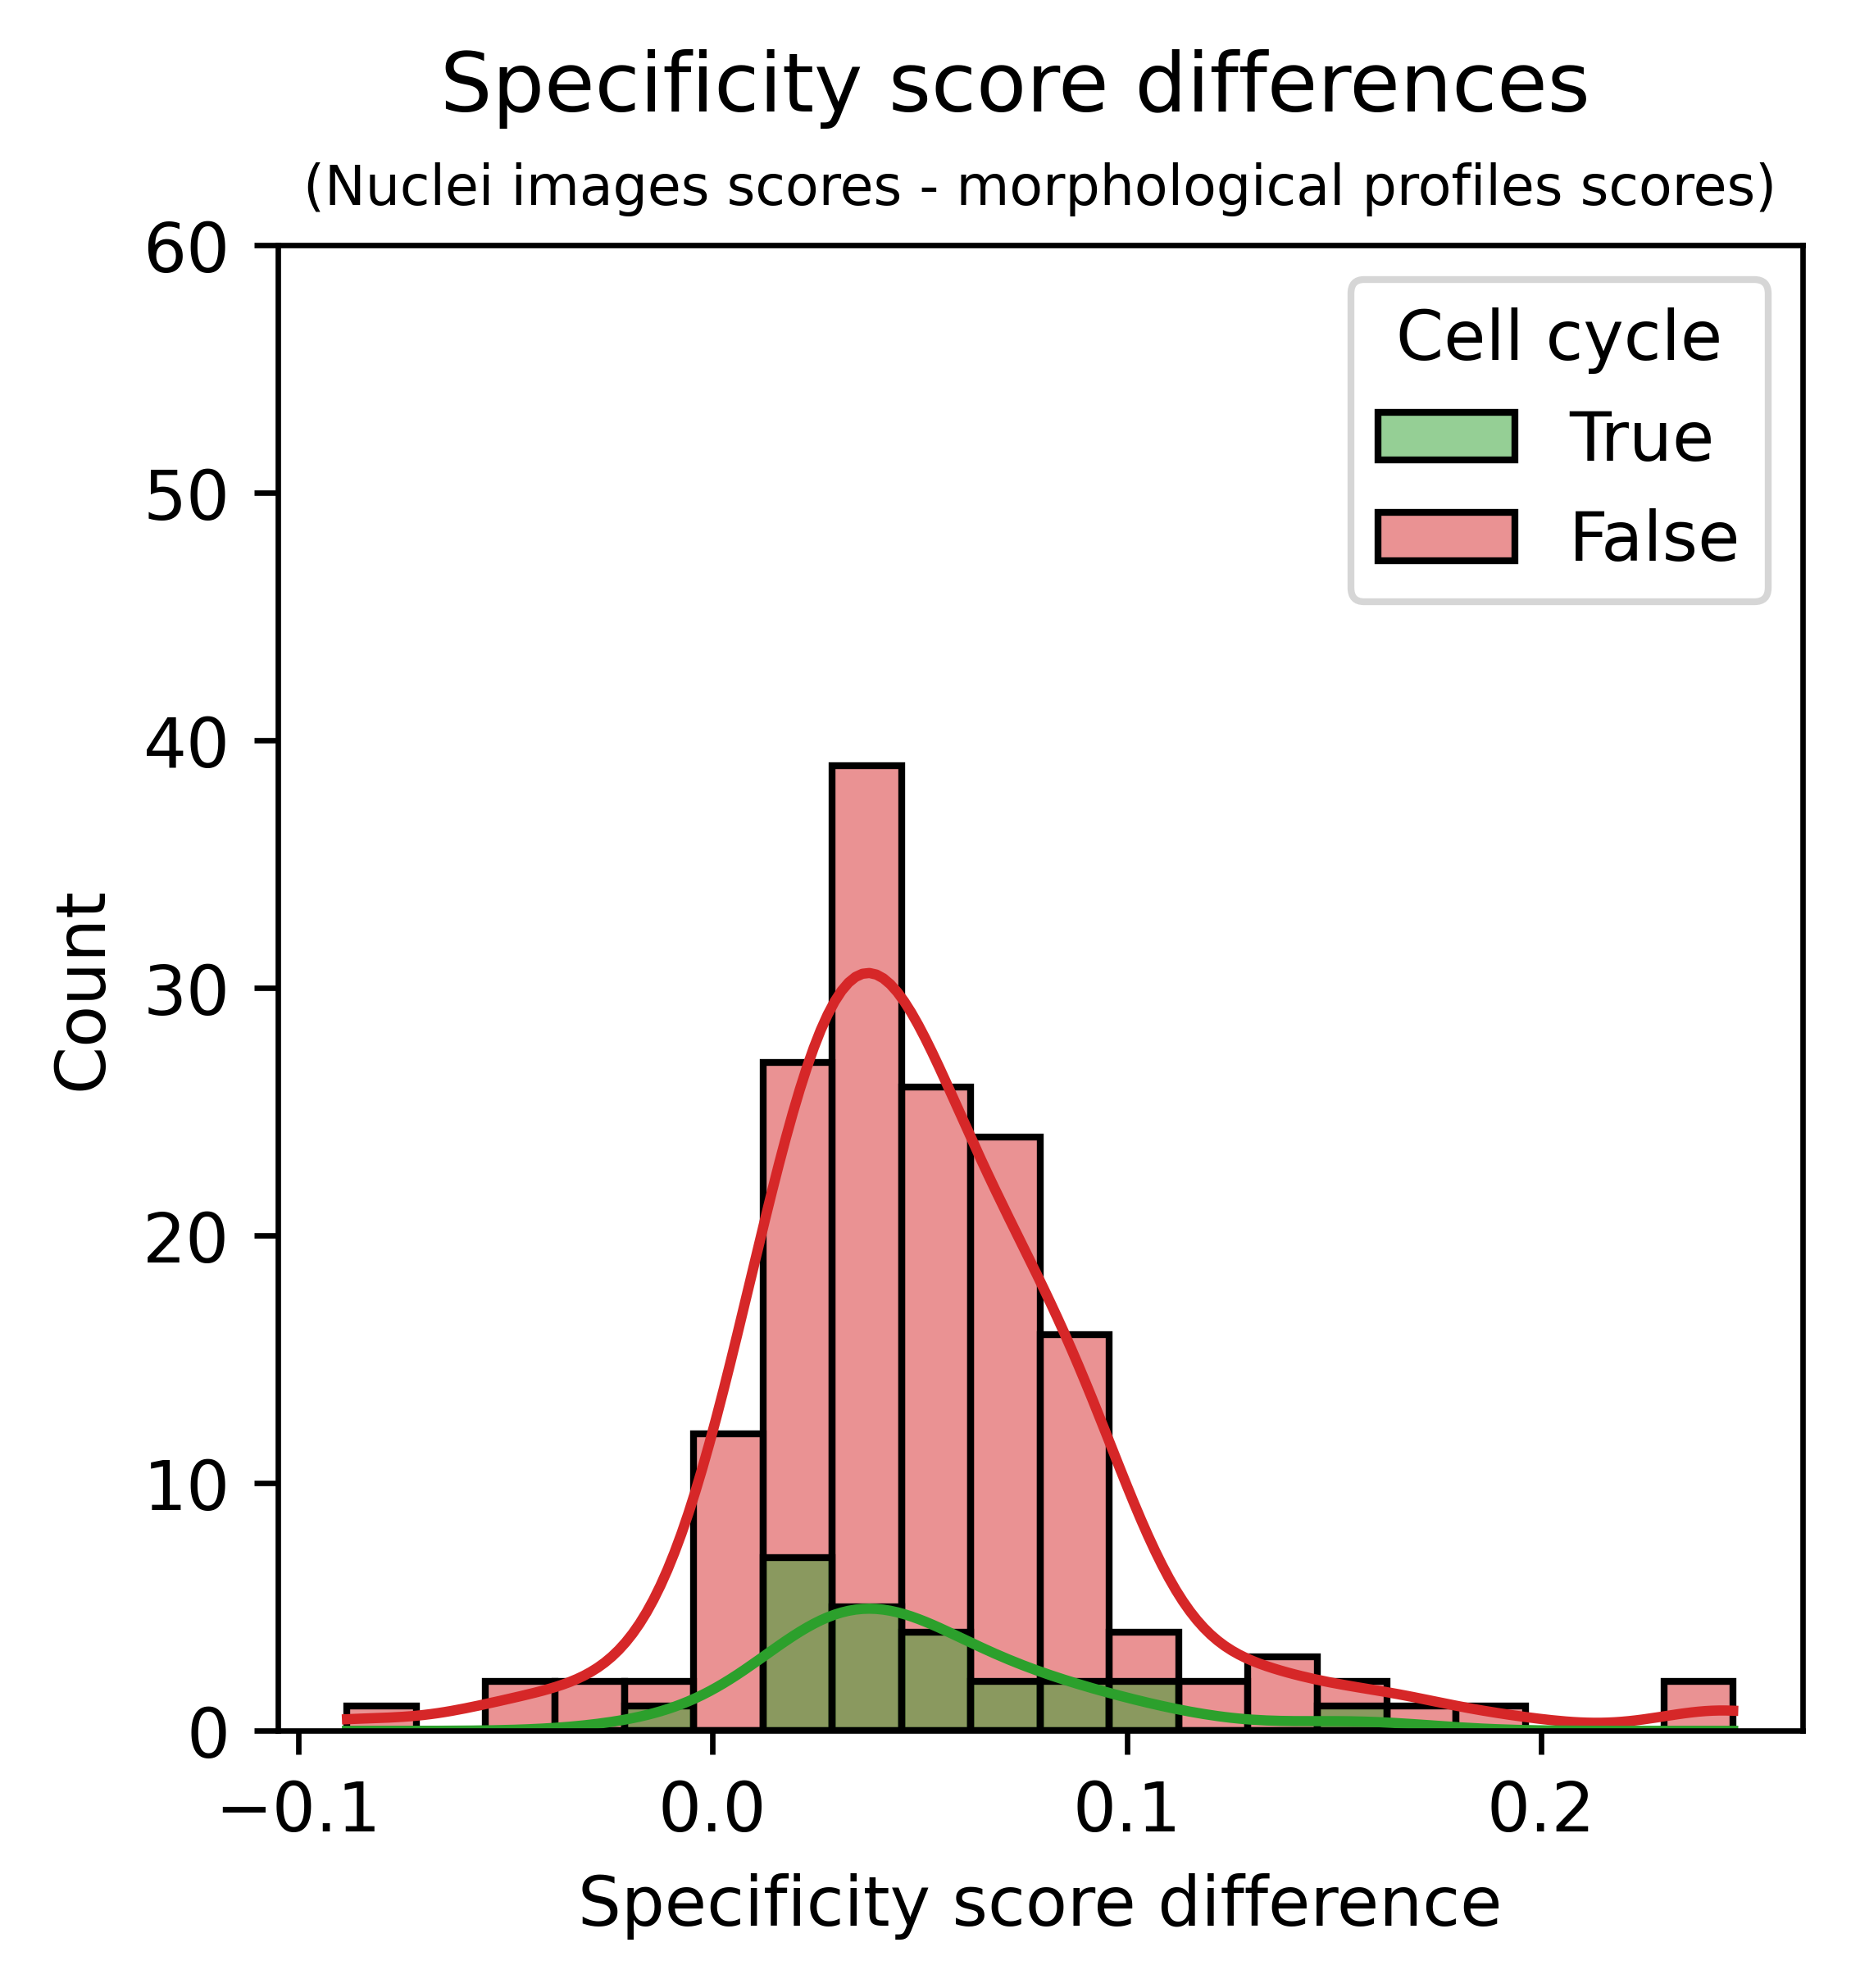

In [16]:
fig, ax = plt.subplots(figsize=[4, 4])
ax = sns.histplot(
    data=nuclei_minus_morph_results,
    x="test_bacc",
    kde=True,
    bins=20,
    alpha=0.5,
    hue="Cell cycle",
    palette=["tab:green", "tab:red"],
    hue_order=[True, False],
)
# ax.set_xlim([-0.3, 0.3])
ax.set_ylim([0, 60])
ax.set_xlabel("Specificity score difference")
plt.suptitle("Specificity score differences")
plt.title("(Nuclei images scores - morphological profiles scores)", fontsize=8)
plt.show()

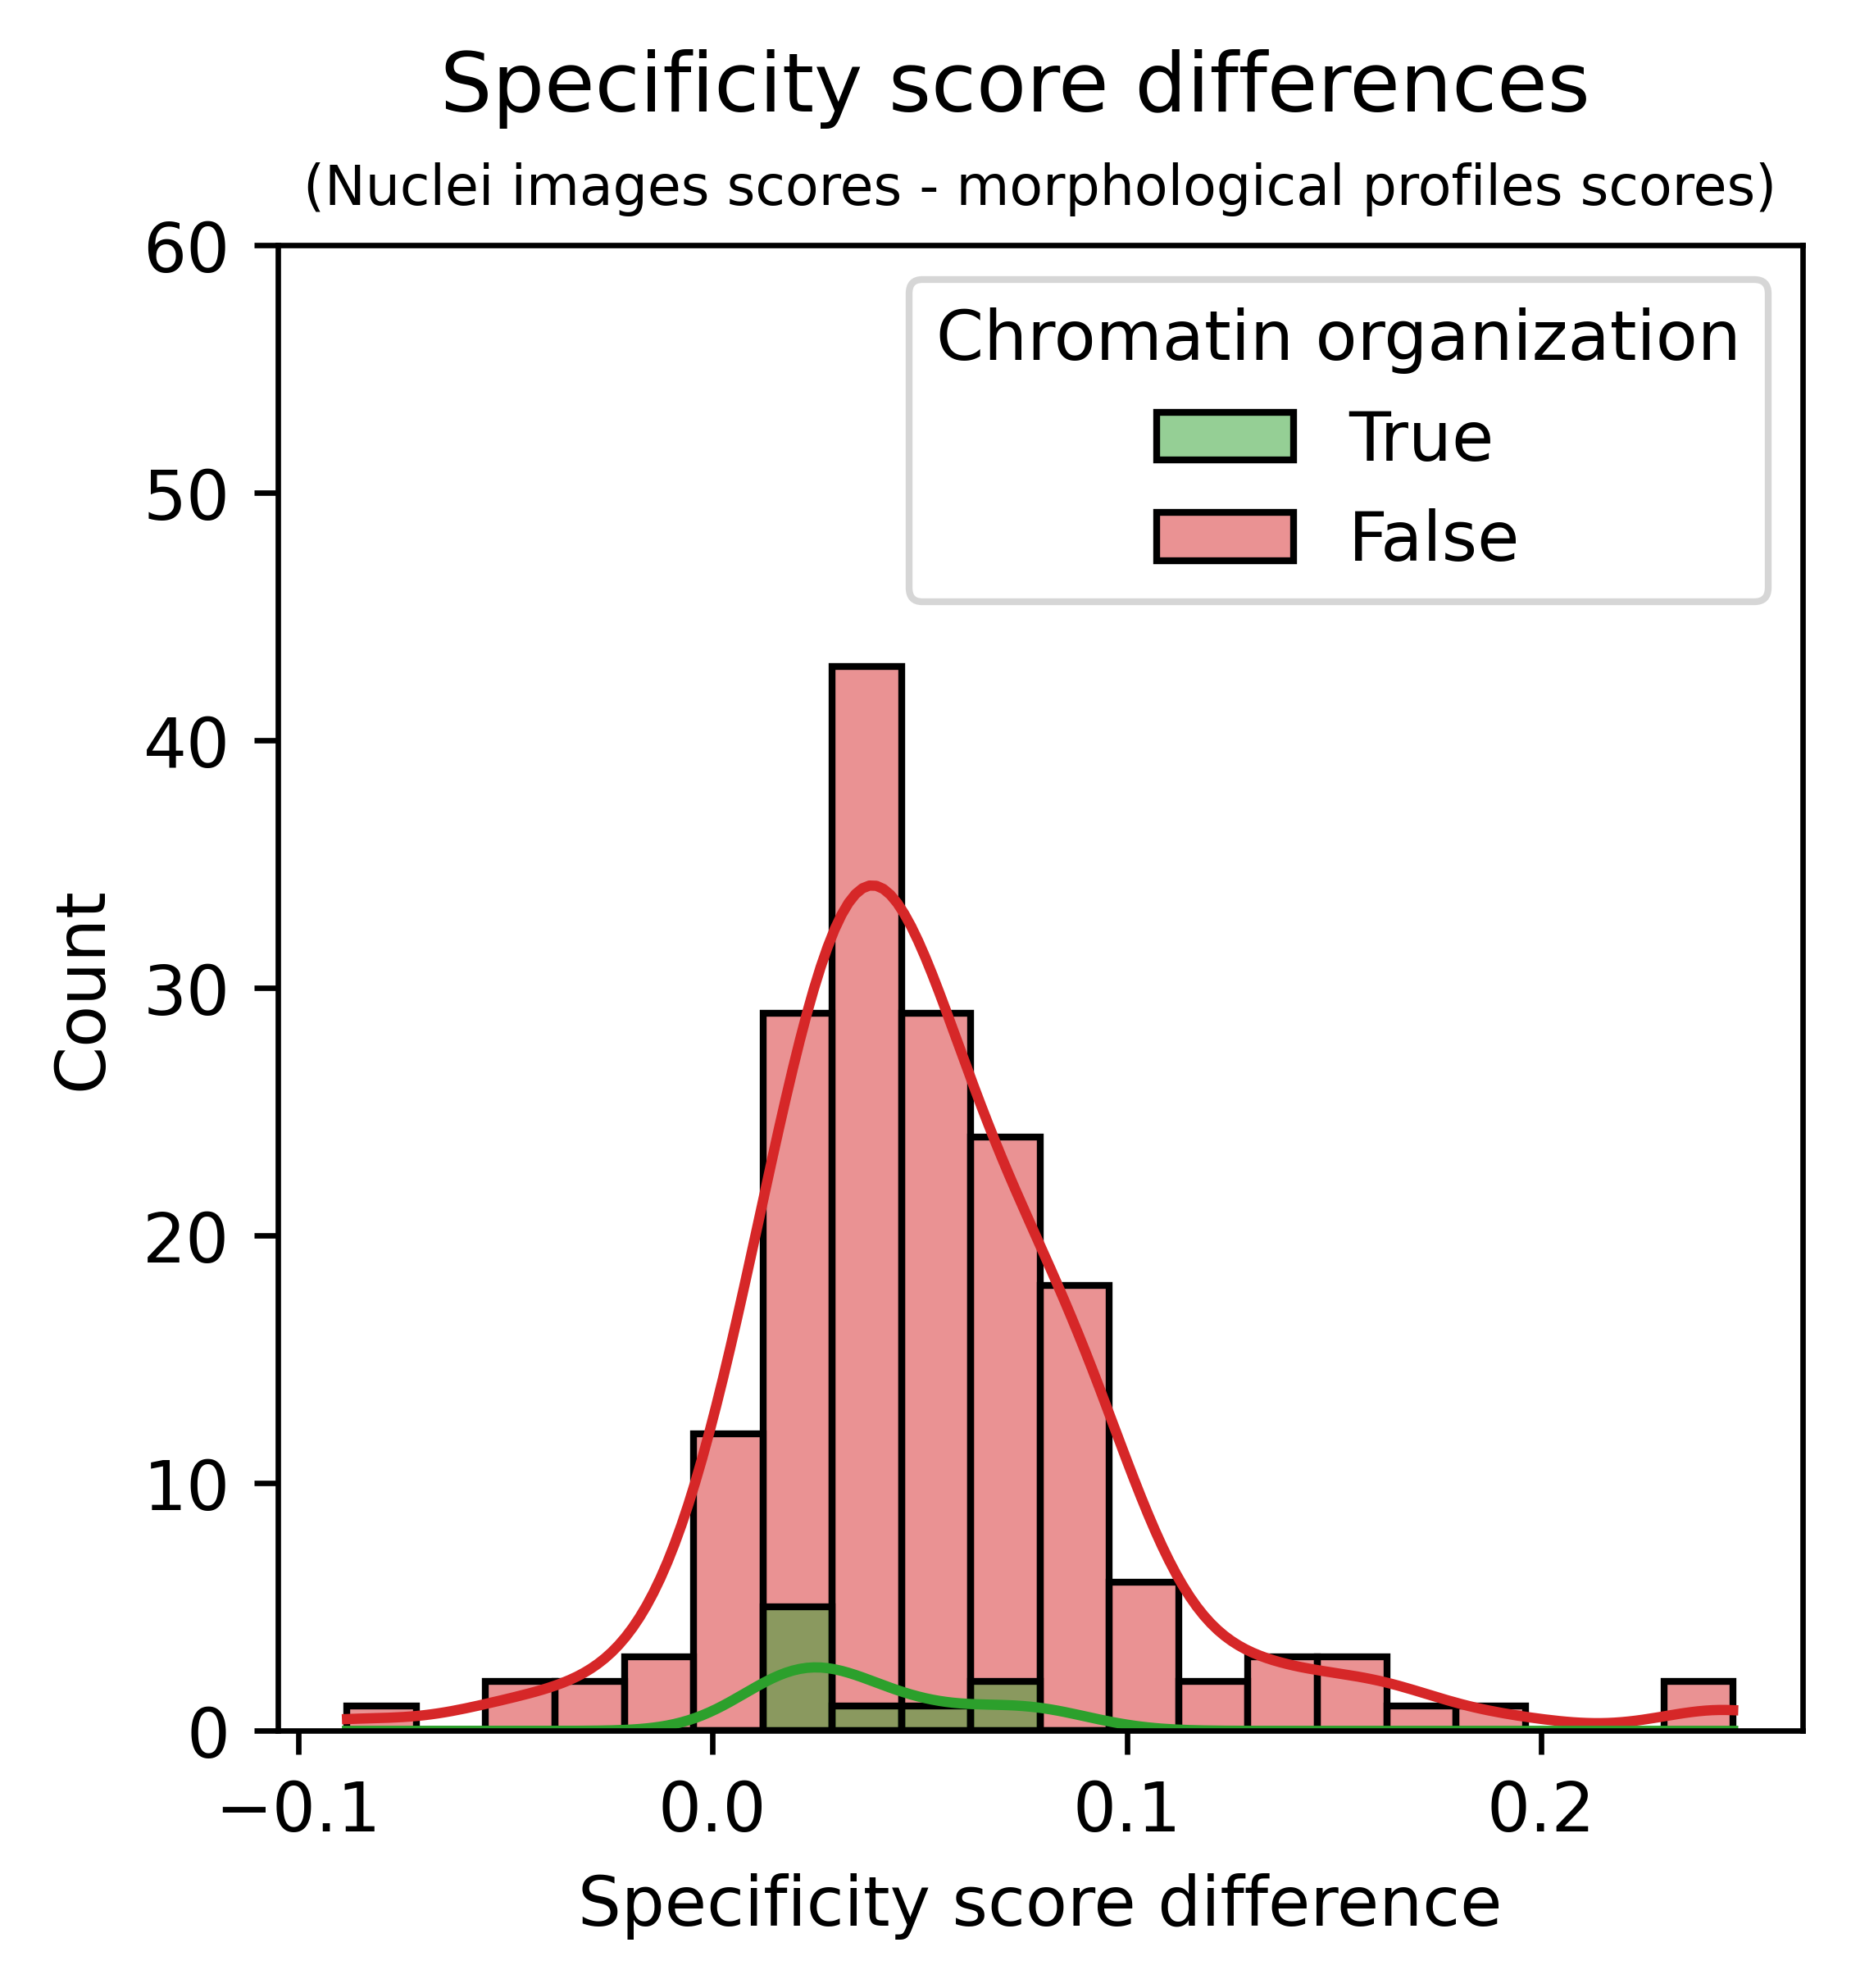

In [17]:
fig, ax = plt.subplots(figsize=[4, 4])
ax = sns.histplot(
    data=nuclei_minus_morph_results,
    x="test_bacc",
    kde=True,
    bins=20,
    alpha=0.5,
    hue="Chromatin organization",
    palette=["tab:green", "tab:red"],
    hue_order=[True, False],
)
# ax.set_xlim([-0.3, 0.3])
ax.set_ylim([0, 60])
ax.set_xlabel("Specificity score difference")
plt.suptitle("Specificity score differences")
plt.title("(Nuclei images scores - morphological profiles scores)", fontsize=8)
plt.show()

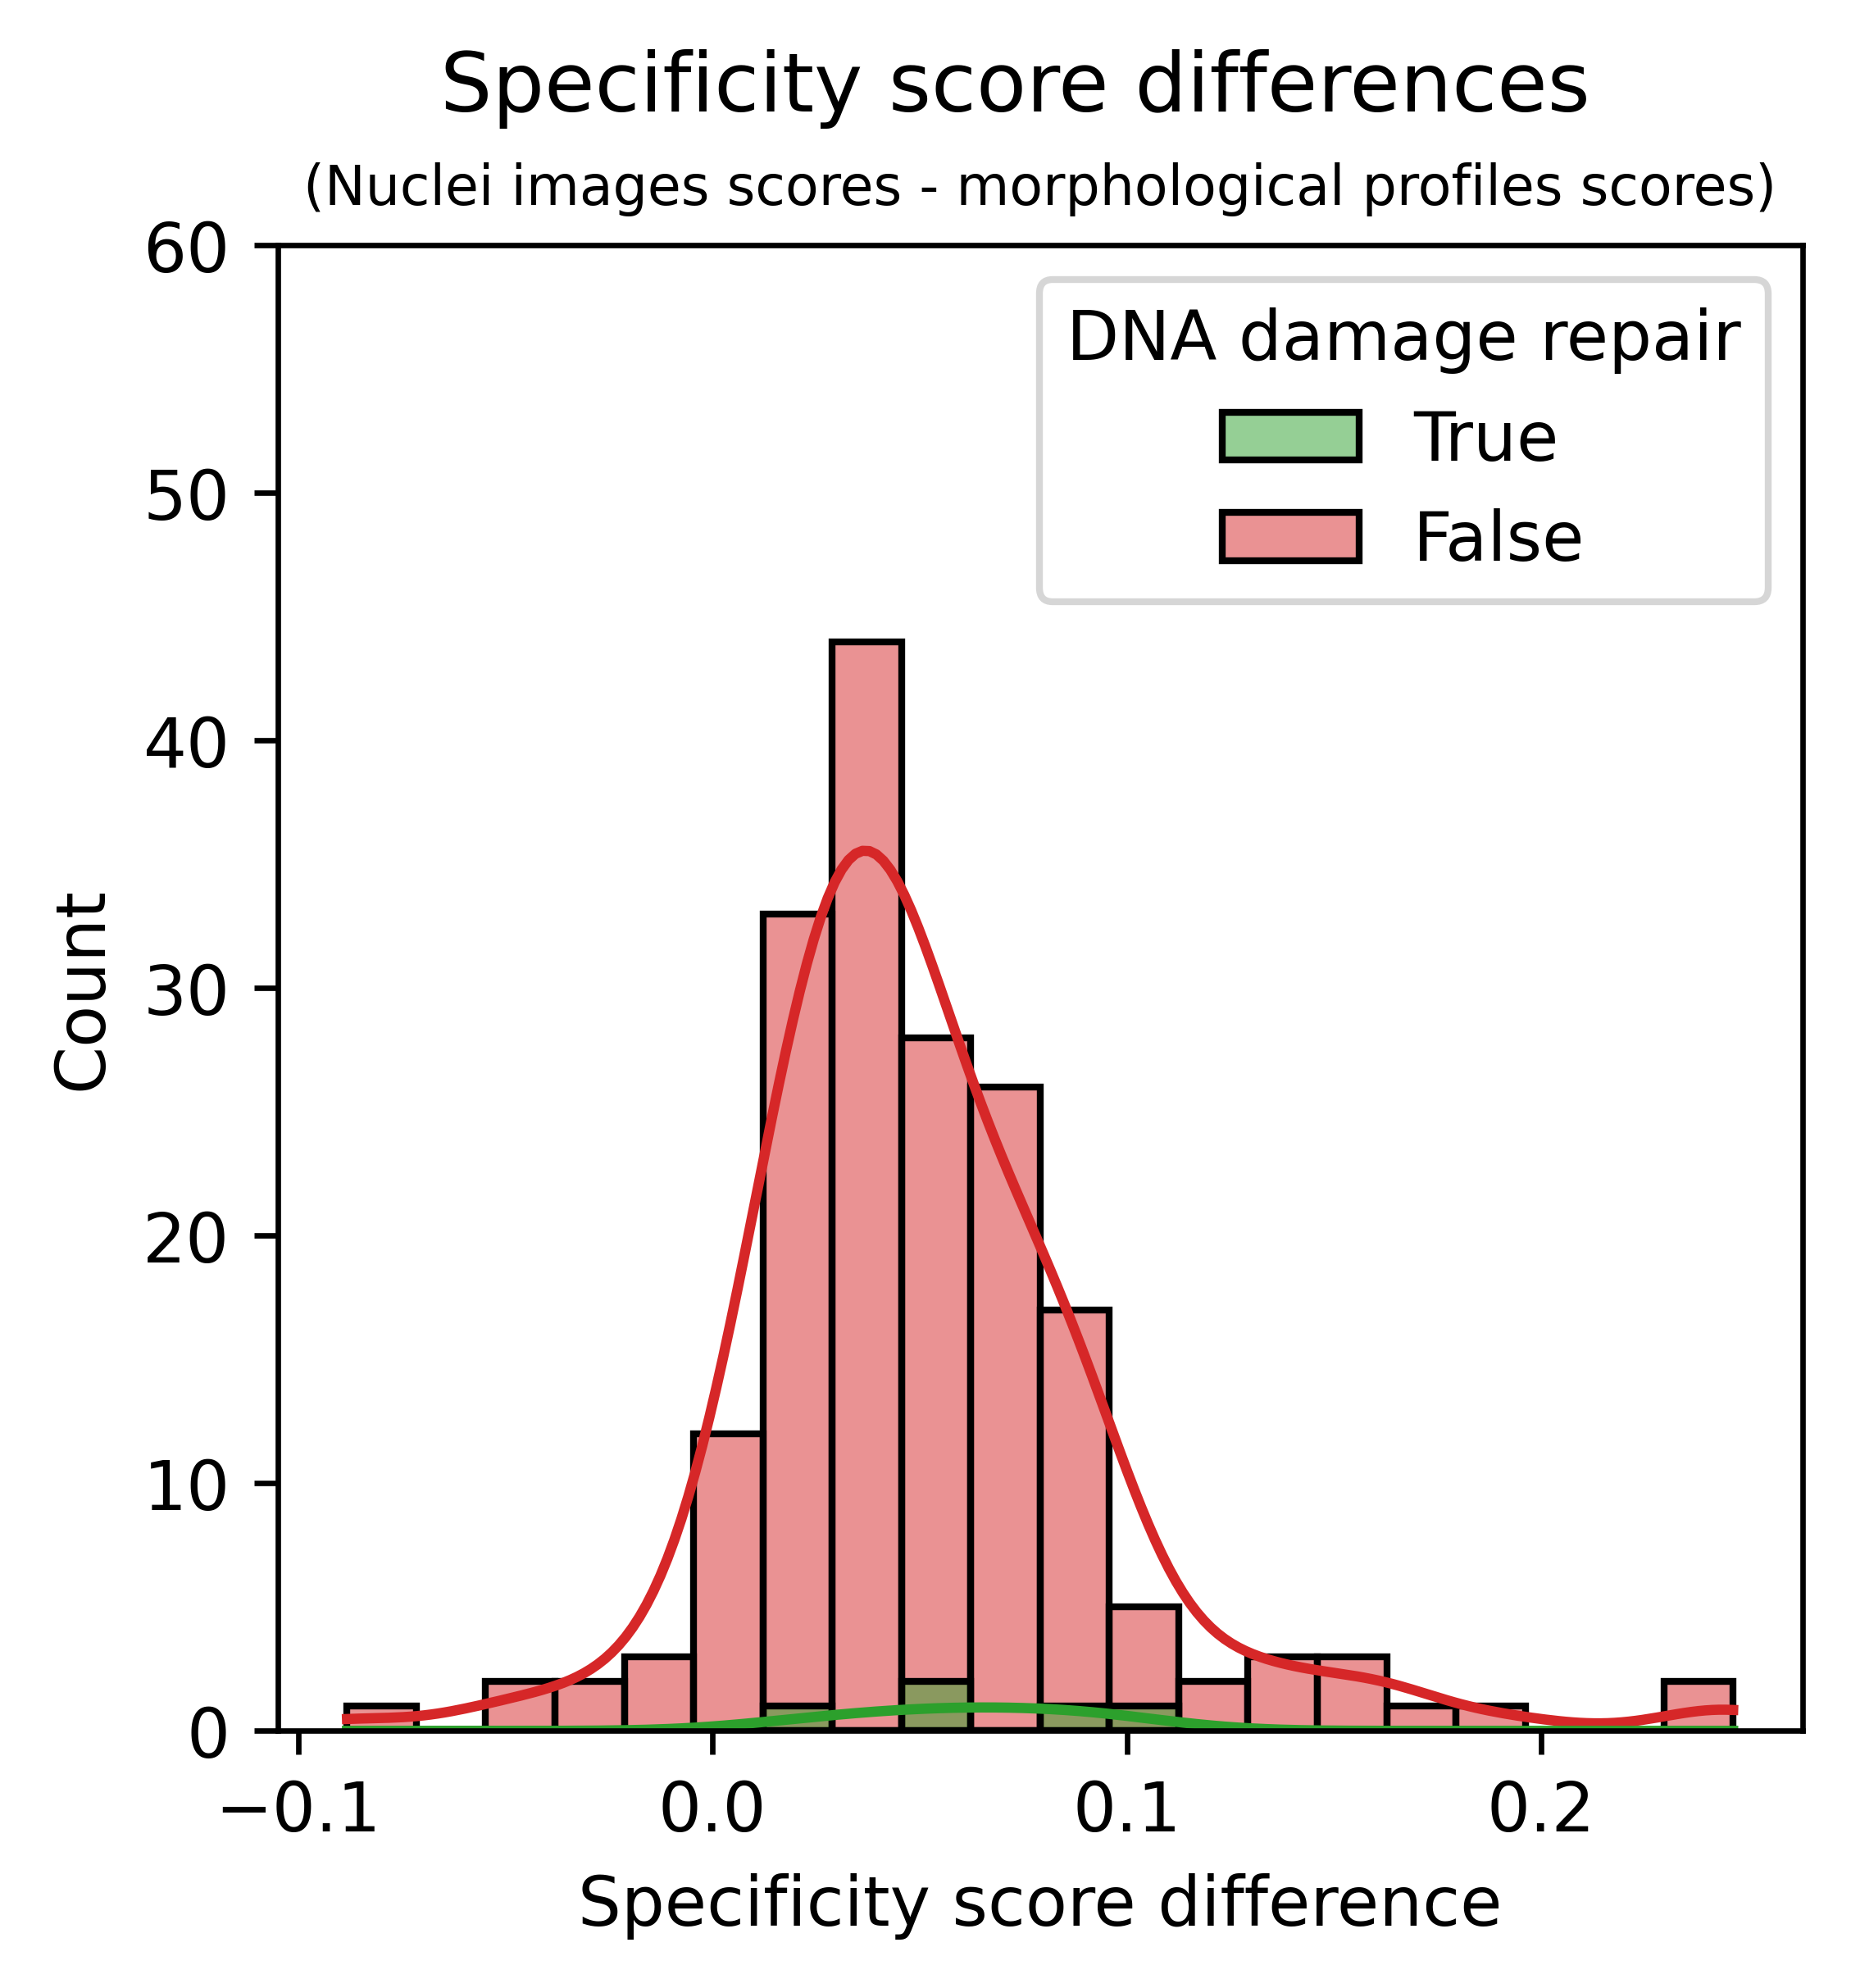

In [18]:
fig, ax = plt.subplots(figsize=[4, 4])
ax = sns.histplot(
    data=nuclei_minus_morph_results,
    x="test_bacc",
    kde=True,
    bins=20,
    alpha=0.5,
    hue="DNA damage repair",
    palette=["tab:green", "tab:red"],
    hue_order=[True, False],
)
# ax.set_xlim([-0.3, 0.3])
ax.set_ylim([0, 60])
ax.set_xlabel("Specificity score difference")
plt.suptitle("Specificity score differences")
plt.title("(Nuclei images scores - morphological profiles scores)", fontsize=8)
plt.show()

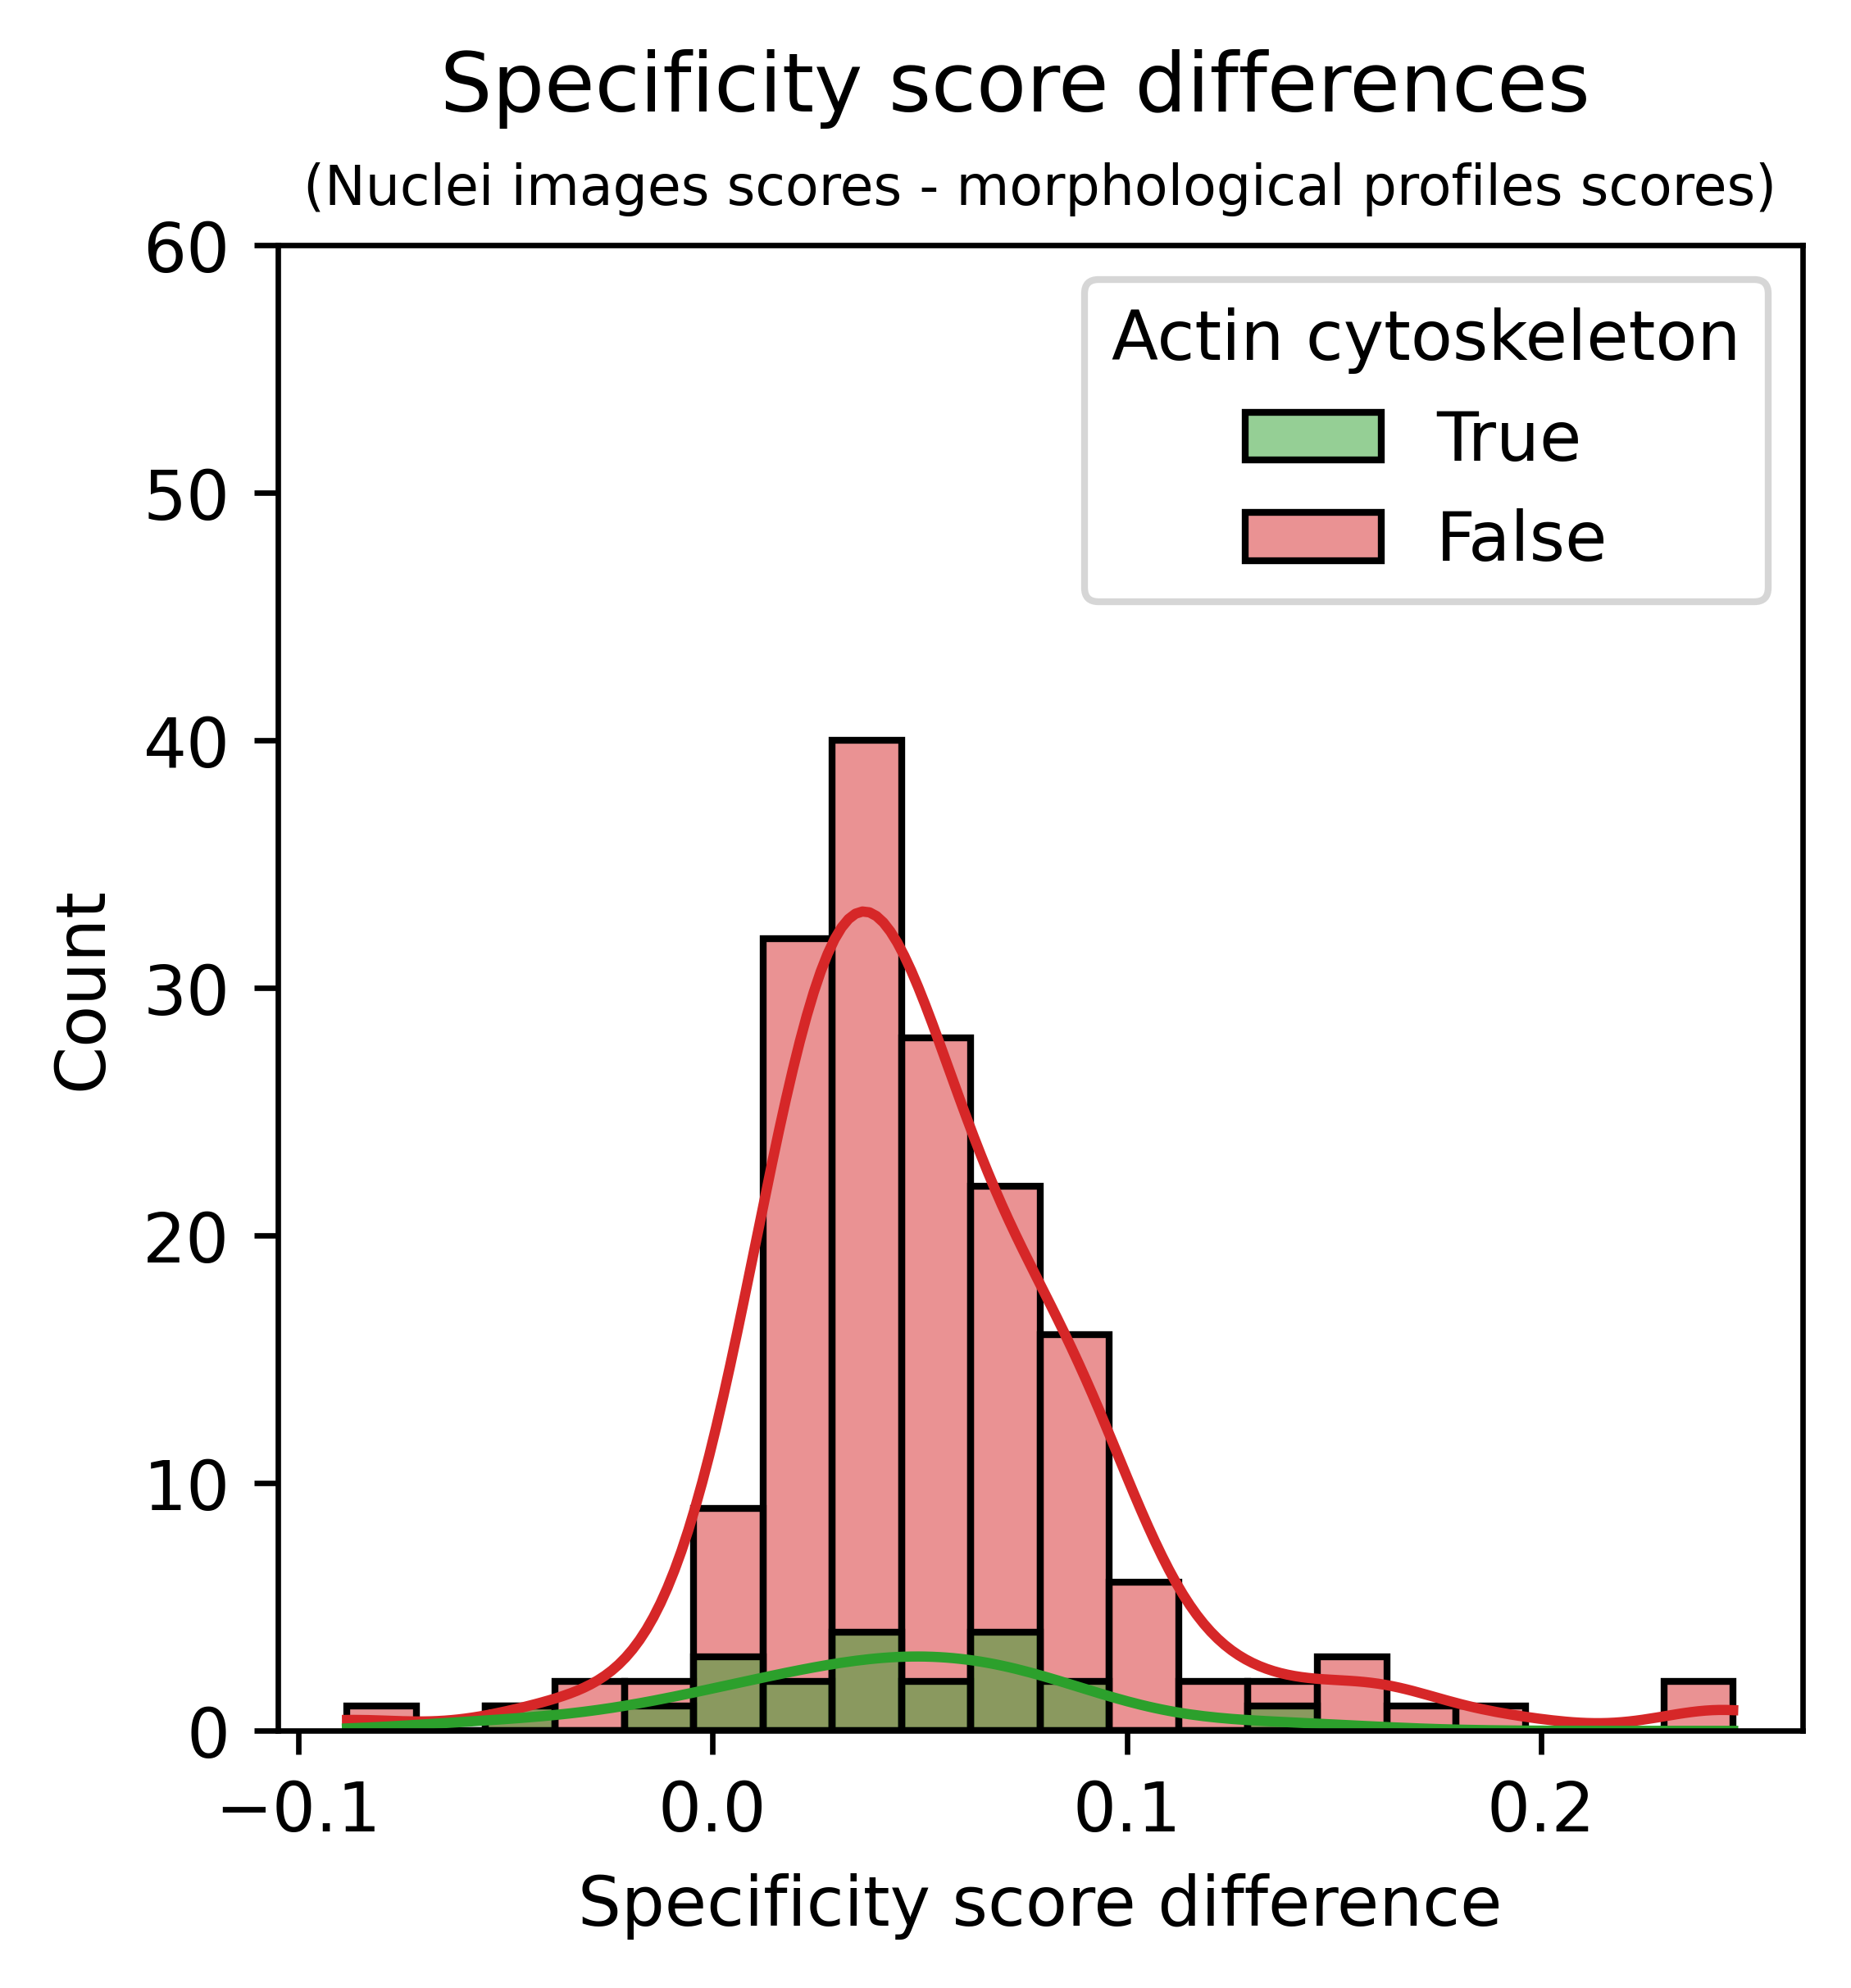

In [19]:
fig, ax = plt.subplots(figsize=[4, 4])
ax = sns.histplot(
    data=nuclei_minus_morph_results,
    x="test_bacc",
    kde=True,
    bins=20,
    alpha=0.5,
    hue="Actin cytoskeleton",
    palette=["tab:green", "tab:red"],
    hue_order=[True, False],
)
# ax.set_xlim([-0.3, 0.3])
ax.set_ylim([0, 60])
ax.set_xlabel("Specificity score difference")
plt.suptitle("Specificity score differences")
plt.title("(Nuclei images scores - morphological profiles scores)", fontsize=8)
plt.show()

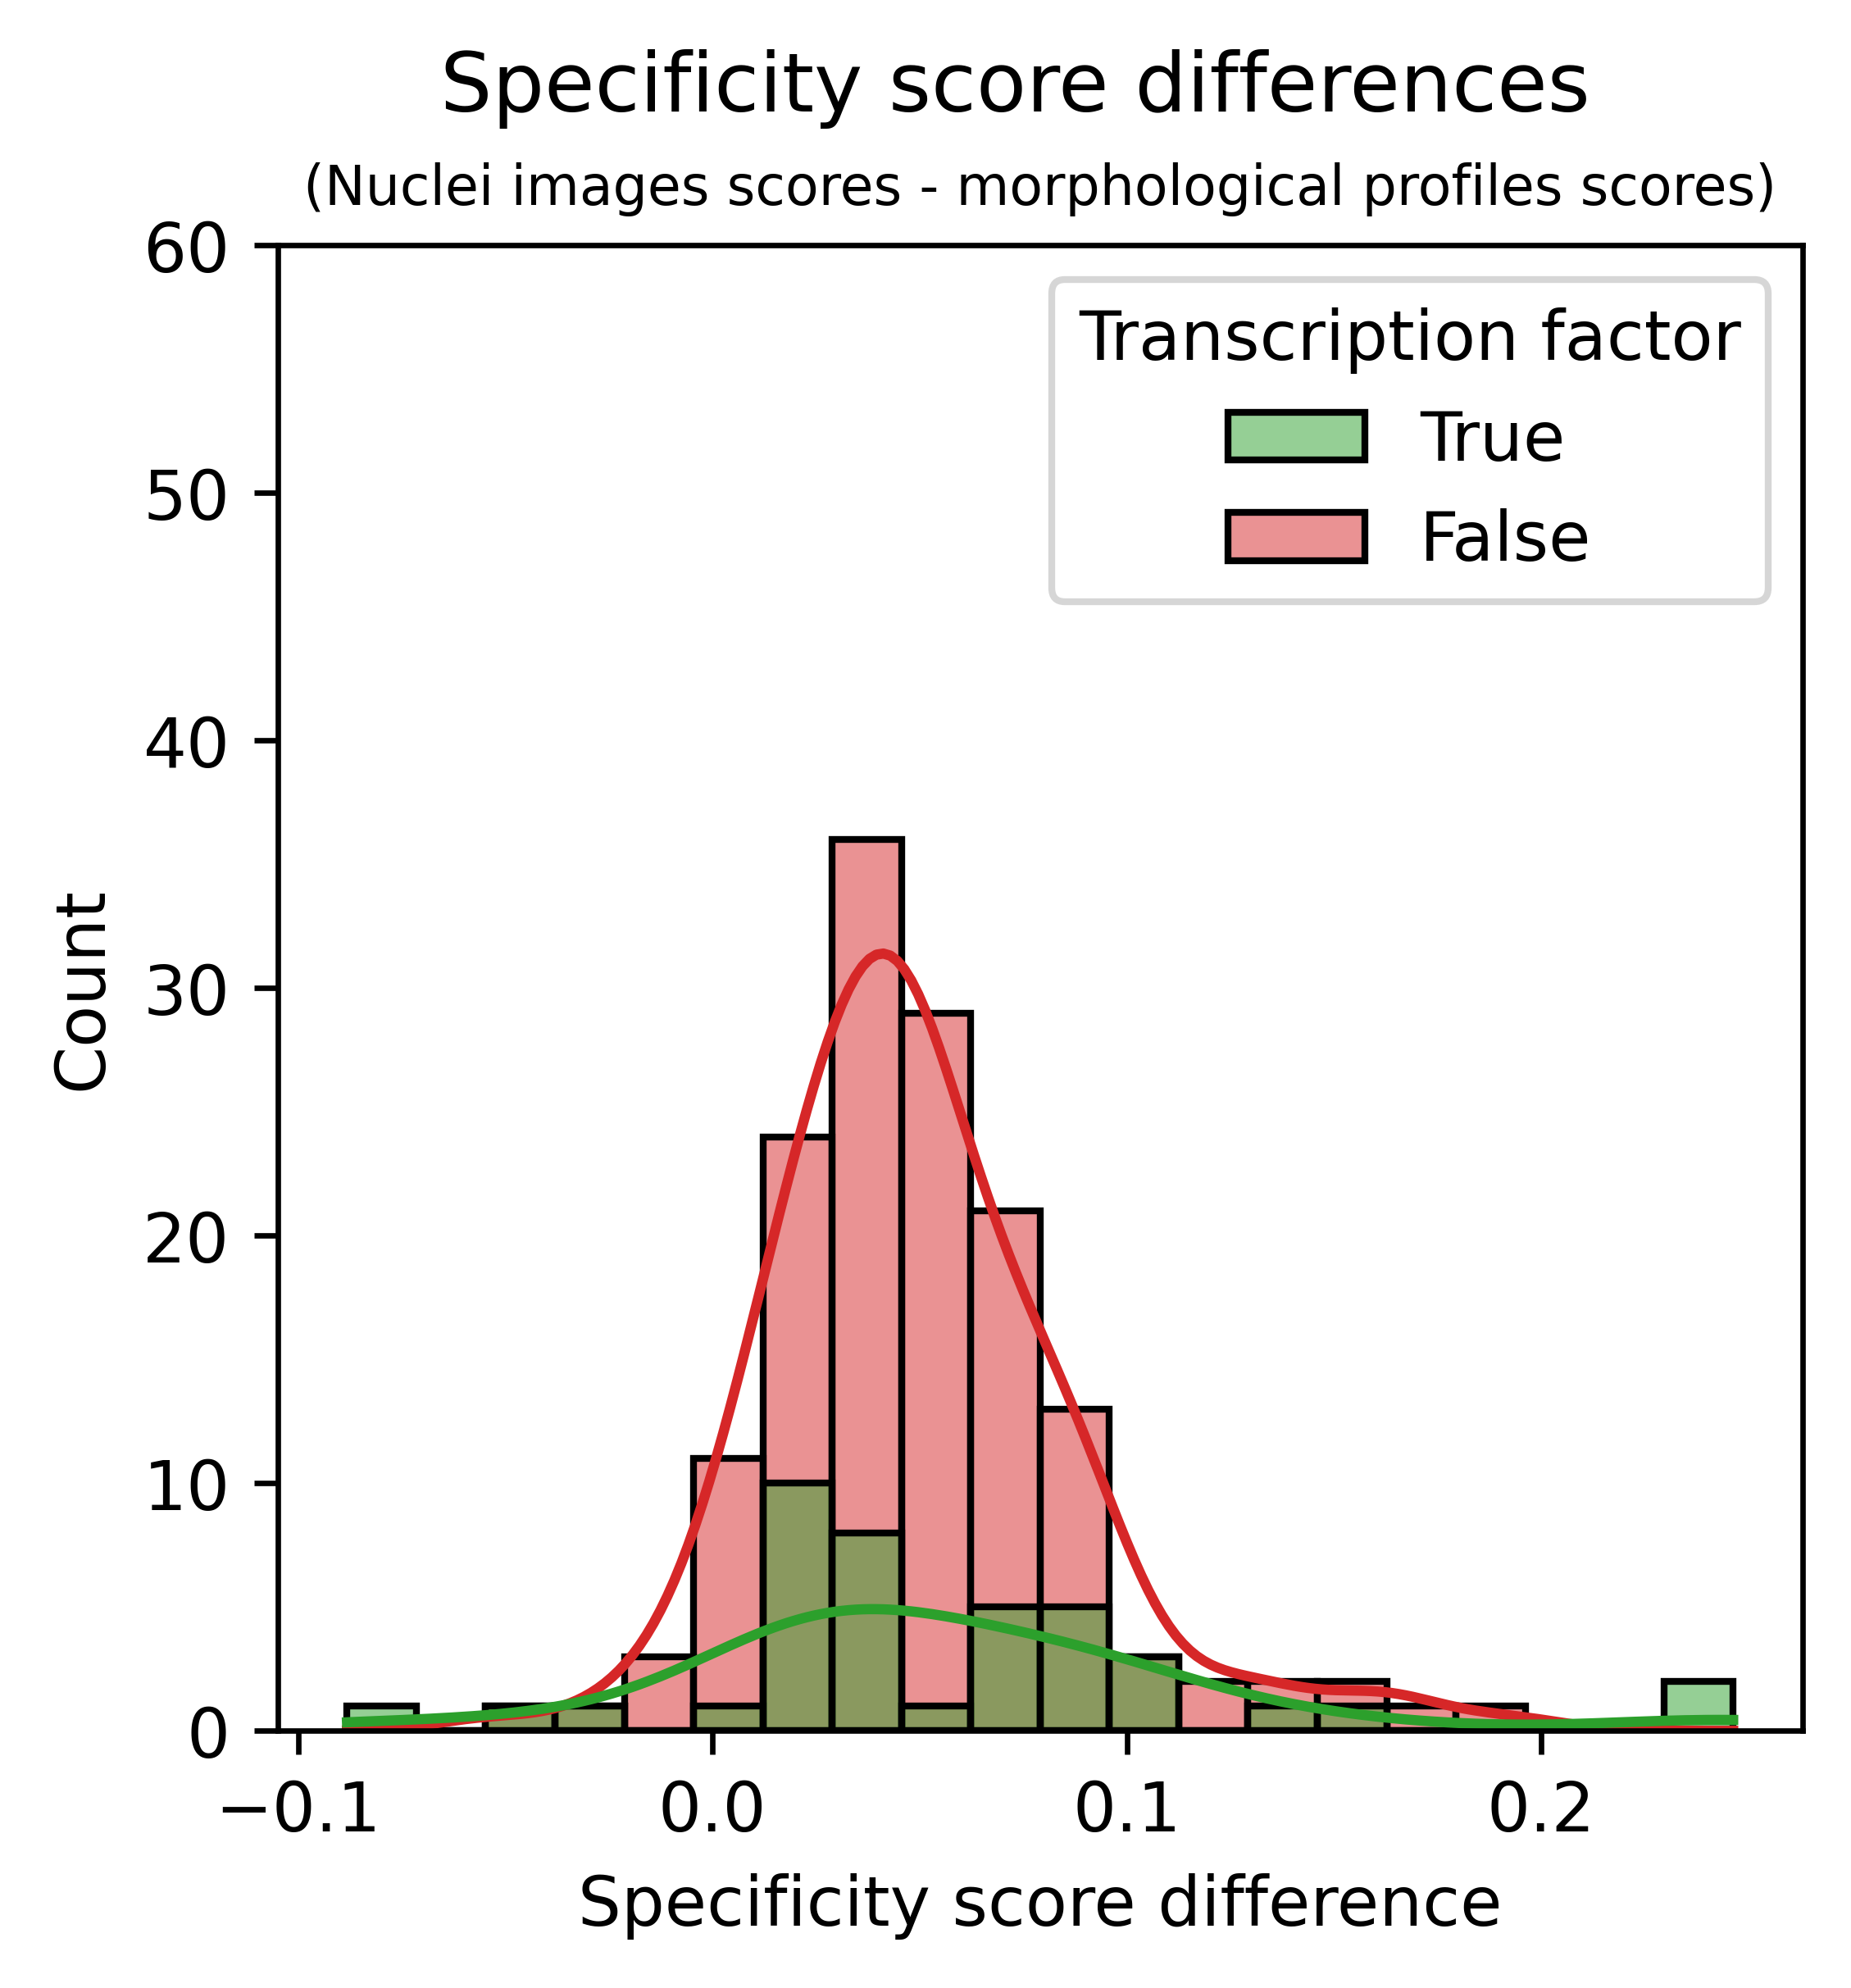

In [20]:
fig, ax = plt.subplots(figsize=[4, 4])
ax = sns.histplot(
    data=nuclei_minus_morph_results,
    x="test_bacc",
    kde=True,
    bins=20,
    alpha=0.5,
    hue="Transcription factor",
    palette=["tab:green", "tab:red"],
    hue_order=[True, False],
)
# ax.set_xlim([-0.3, 0.3])
ax.set_ylim([0, 60])
ax.set_xlabel("Specificity score difference")
plt.suptitle("Specificity score differences")
plt.title("(Nuclei images scores - morphological profiles scores)", fontsize=8)
plt.show()

---

Let us also check the genes for which we observe a higher specificity score using the morphological profiles.

In [21]:
print(
    toxic_genes.intersection(
        nuclei_minus_morph_results.loc[nuclei_minus_morph_results.test_bacc < 0].index
    )
)

nuclei_minus_morph_results.loc[nuclei_minus_morph_results.test_bacc < 0].sort_values(
    "test_bacc"
)

{'ERG', 'CEBPA', 'JUN', 'PRKACA'}


train_loss  val_loss  test_loss  train_acc   val_acc  test_acc  \
target                                                                   
JUN       0.021289  0.105744   0.110036  -0.034162 -0.078949 -0.088297   
BRAF     -0.008499  0.050456   0.044981   0.000871 -0.073787 -0.052859   
ERG      -0.100090  0.064953   0.067675   0.069596 -0.043237 -0.046368   
CEBPA    -0.019445  0.027406   0.043604   0.005765 -0.027070 -0.028542   
PDPK1    -0.032369  0.018126   0.024210   0.024770 -0.007468 -0.025961   
CDC42     0.015048  0.024616   0.005250  -0.016469 -0.036479 -0.019984   
PRKACA   -0.075699  0.041711   0.015406   0.079848 -0.020661 -0.010170   
TGFBR1   -0.030228 -0.009883  -0.013766   0.019180  0.005732 -0.004886   
NOTCH1   -0.069452 -0.050417  -0.033144   0.050673  0.021650 -0.001993   
PIK3CD   -0.114096 -0.025605  -0.046703   0.115123  0.018226  0.000174   
EIF2A    -0.058718 -0.057739  -0.023983   0.049301  0.054616 -0.000868   

        train_bacc  val_bacc  test_bacc  Cell cycle  Chromatin organization  \
target                                                                        
JUN      -0.033988 -0.089667  -0.088201       False                   False   
BRAF     -0.000679 -0.064730  -0.053383       False                   False   
ERG       0.068591 -0.045195  -0.046618       False                   False   
CEBPA     0.002896 -0.038326  -0.029631       False                   False   
PDPK1     0.024614 -0.009826  -0.026067       False                   False   
CDC42    -0.019651 -0.019856  -0.019593       False                   False   
PRKACA    0.080368 -0.025116  -0.009196        True                   False   
TGFBR1    0.021146 -0.009251  -0.005120       False                   False   
NOTCH1    0.050458  0.021260  -0.002106       False                   False   
PIK3CD    0.115987  0.008554  -0.000758       False                   False   
EIF2A     0.047934  0.060126  -0.000298       False                   False   

        DNA damage repair  Actin cytoskeleton  Transcription factor  
target                                                               
JUN                 False               False                  True  
BRAF                False                True                 False  
ERG                 False               False                  True  
CEBPA               False               False                  True  
PDPK1               False               False                 False  
CDC42               False                True                 False  
PRKACA              False               False                 False  
TGFBR1              False               False                 False  
NOTCH1              False               False                 False  
PIK3CD              False                True                 False  
EIF2A               False               False                 False

In total we find 11 genes for which that is the case. Interestingly among these are four genes that were flagged for having a toxic effect among overexpression, namely: JUN, ERG, CEBPA and PRKACA. The toxic effect of these genes is reflected in the change of the cell density that is partially described using four features in the morphological profiles but not in the single-nuclei images. As expected, we find that these genes achieve high specificity scores when we not only use the single-nuclei but also the region image as shown below. The latter image input enables the network to e.g. also derive cell density information and use those for prediction.

In [22]:
pos_score_dif_genes = nuclei_minus_morph_results.loc[
    nuclei_minus_morph_results.test_bacc > 0
].index
neg_score_dif_genes = nuclei_minus_morph_results.loc[
    nuclei_minus_morph_results.test_bacc < 0
].index

toxic_cont_table = np.zeros((2, 2))
toxic_cont_table = pd.DataFrame(
    toxic_cont_table,
    index=["Toxic", "Not toxic"],
    columns=["Negative score difference", "Positive score difference"],
)
toxic_cont_table.loc["Toxic", "Negative score difference"] = len(
    toxic_genes.intersection(neg_score_dif_genes)
)
toxic_cont_table.loc["Not toxic", "Negative score difference"] = len(
    set(neg_score_dif_genes) - toxic_genes
)
toxic_cont_table.loc["Toxic", "Positive score difference"] = len(
    toxic_genes.intersection(pos_score_dif_genes)
)
toxic_cont_table.loc["Not toxic", "Positive score difference"] = len(
    set(pos_score_dif_genes) - toxic_genes
)

print("Fisher exact test:", fisher_exact(toxic_cont_table))
toxic_cont_table

Fisher exact test: (10.793650793650794, 0.0033945753040687384)


Negative score difference  Positive score difference
Toxic                            4.0                        9.0
Not toxic                        7.0                      170.0

In [23]:
neg_score_dif_genes.intersection(toxic_genes)

Index(['CEBPA', 'ERG', 'JUN', 'PRKACA'], dtype='object', name='target')

<AxesSubplot:>

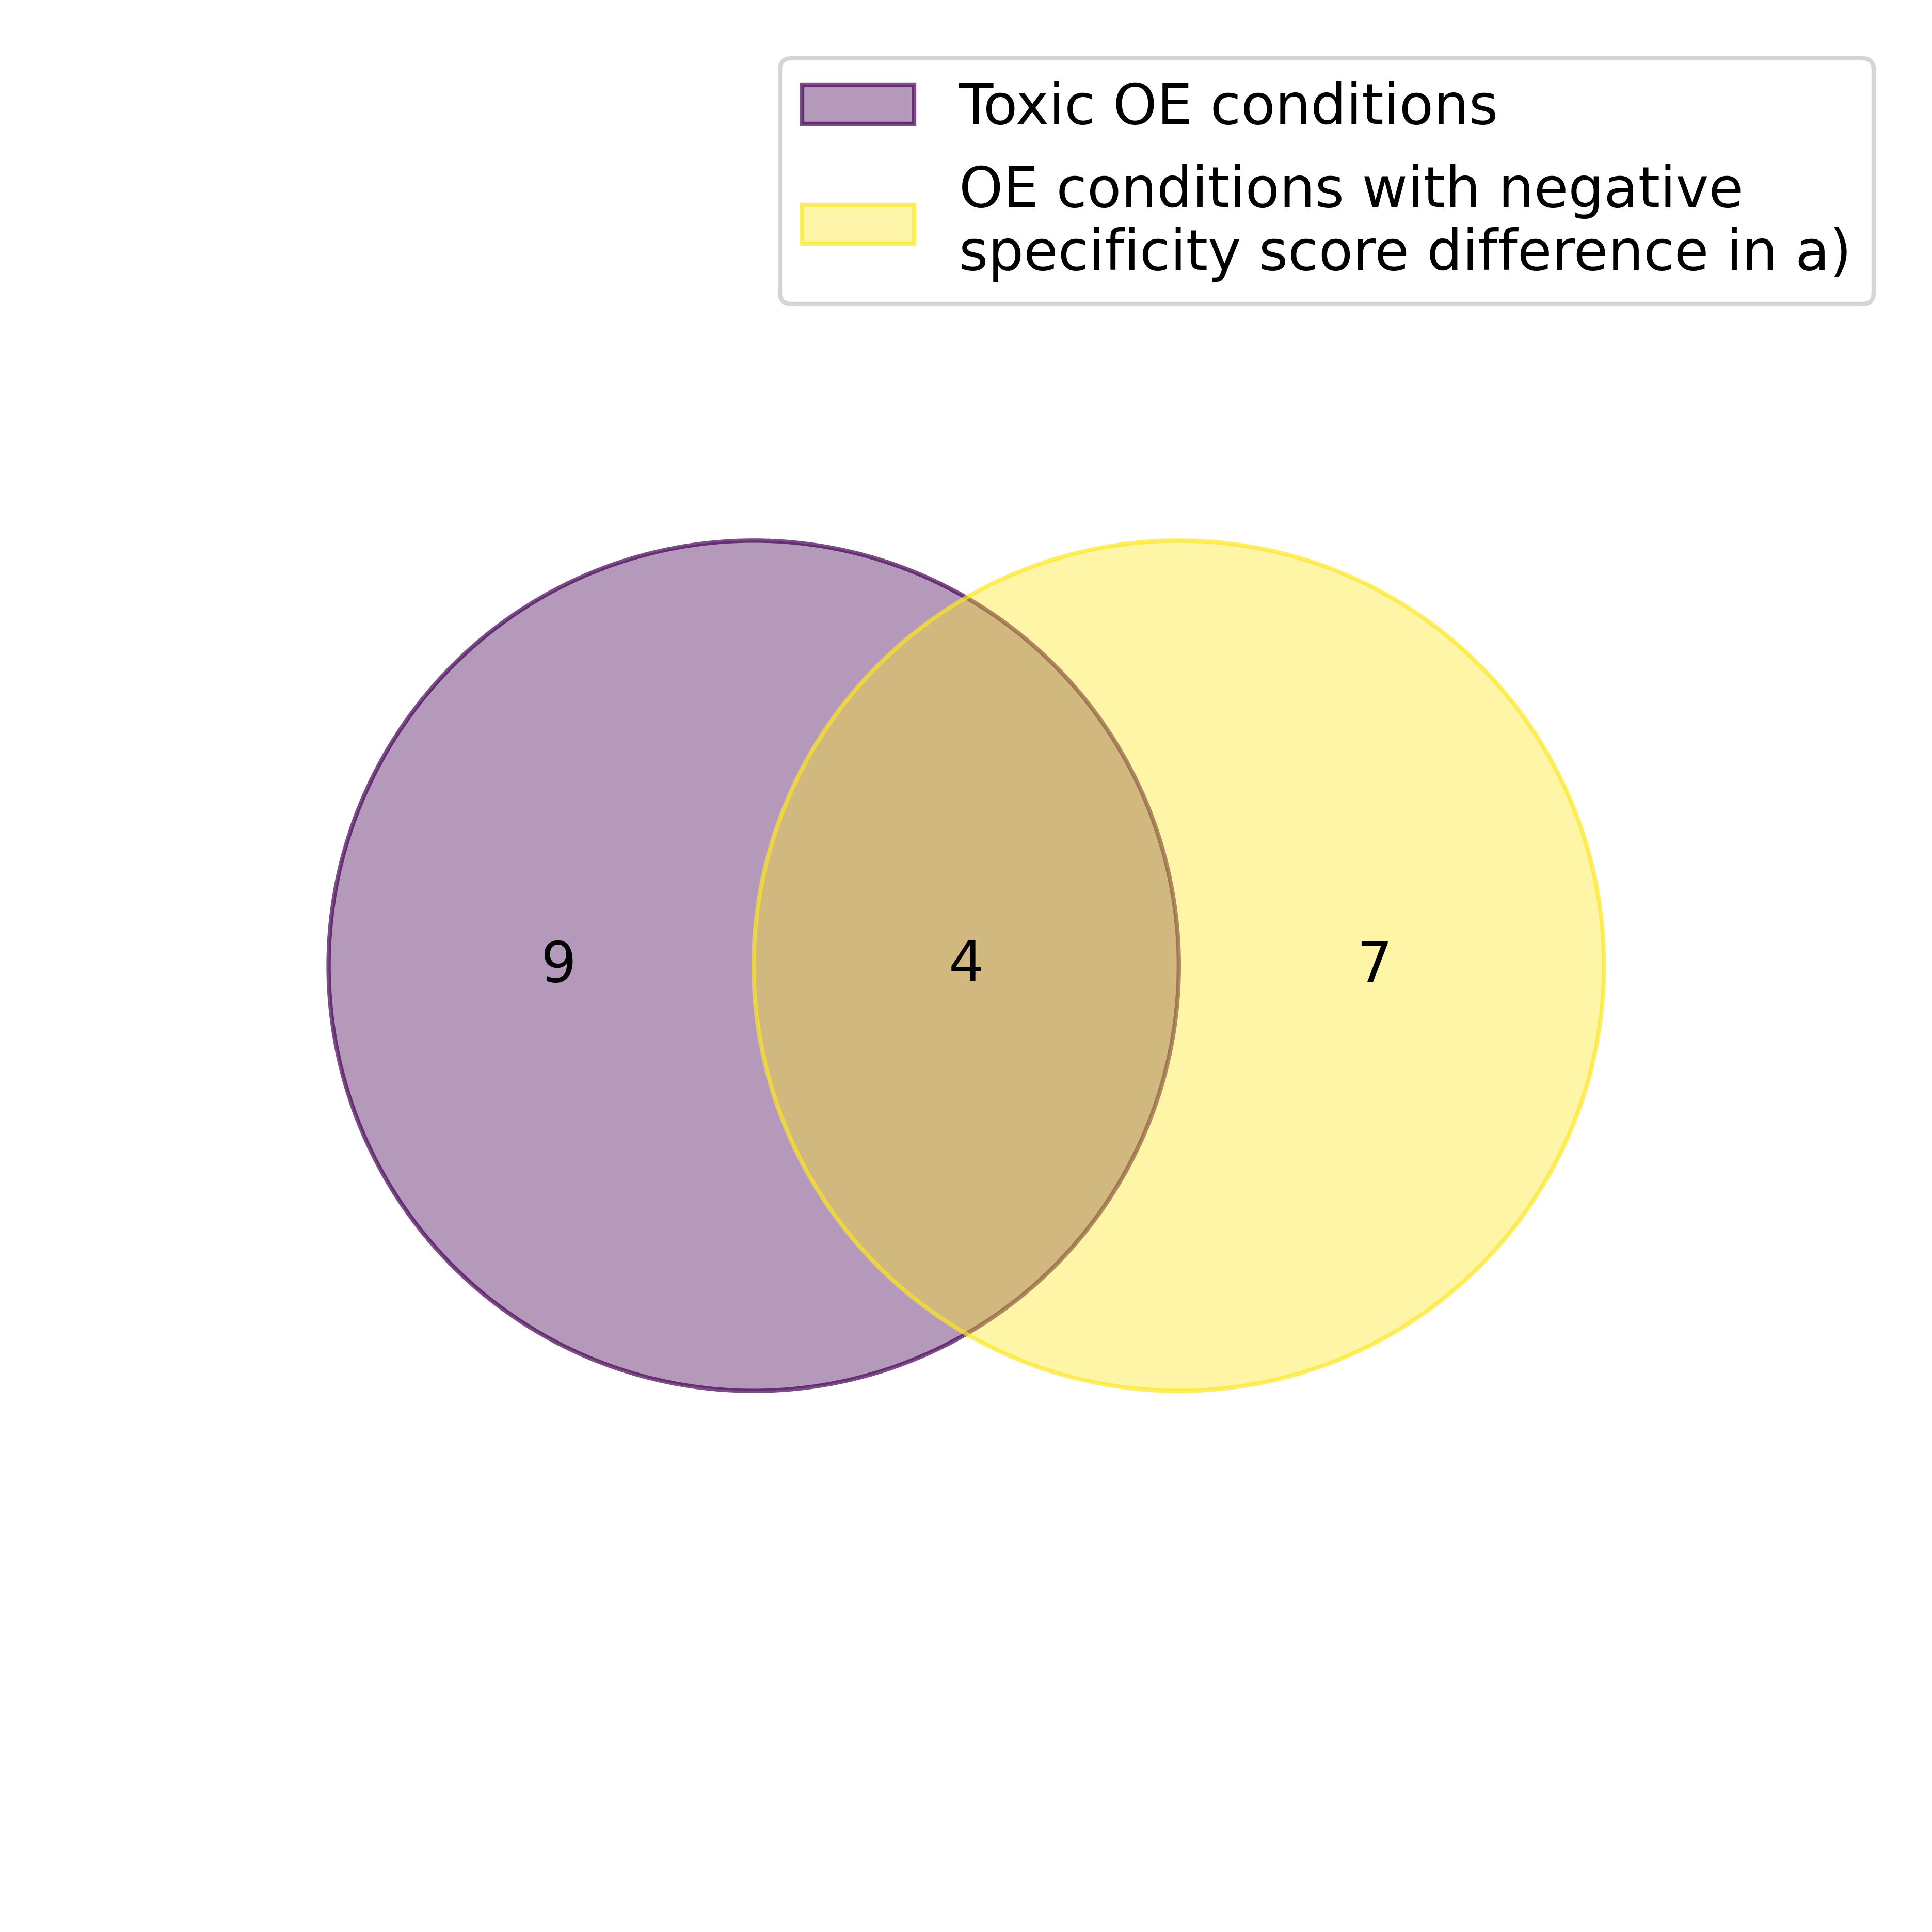

In [24]:
venn.venn(
    {
        "Toxic OE conditions": toxic_genes,
        "OE conditions with negative \nspecificity score difference in a)": set(
            neg_score_dif_genes
        ),
    }
)

A Fisher's exact test validates that the set of gene targets with better specificity scores using the morphological profiles is significantly enriched for gene targets that were flagged as toxic.

---

#### 2.2.2 Morphological profiles vs. Nuclei + region images

We next, also compare the specificity scores obtained for the multi-image inputs, i.e. the nuclei and region images, to those obtained for the morphological profiles.

In [25]:
avg_multi_results = multi_results.groupby("target").mean()

multi_minus_morph_results = avg_multi_results - avg_morph_results
multi_minus_morph_results.describe()

train_loss    val_loss   test_loss   train_acc     val_acc    test_acc  \
count  190.000000  190.000000  190.000000  190.000000  190.000000  190.000000   
mean    -0.347076    0.022104    0.018874    0.286873    0.123718    0.123026   
std      0.126698    0.172832    0.162648    0.081616    0.074277    0.069484   
min     -0.729519   -0.504593   -0.662477    0.108016   -0.001737    0.003235   
25%     -0.438411   -0.065532   -0.060821    0.228651    0.075101    0.078624   
50%     -0.333705    0.008155    0.004878    0.284127    0.111236    0.109945   
75%     -0.252627    0.102439    0.101857    0.344624    0.156747    0.151165   
max     -0.088125    0.685506    0.494621    0.525574    0.508984    0.475781   

       train_bacc    val_bacc   test_bacc  
count  190.000000  190.000000  190.000000  
mean     0.287322    0.124886    0.123325  
std      0.081426    0.076847    0.069723  
min      0.111709    0.001083    0.003297  
25%      0.229506    0.076595    0.079496  
50%      0.283359    0.110545    0.109844  
75%      0.345600    0.153194    0.151555  
max      0.523894    0.569812    0.477152

t-test for zero-mean Ttest_1sampResult(statistic=24.381194541271817, pvalue=1.4564399379469454e-60)


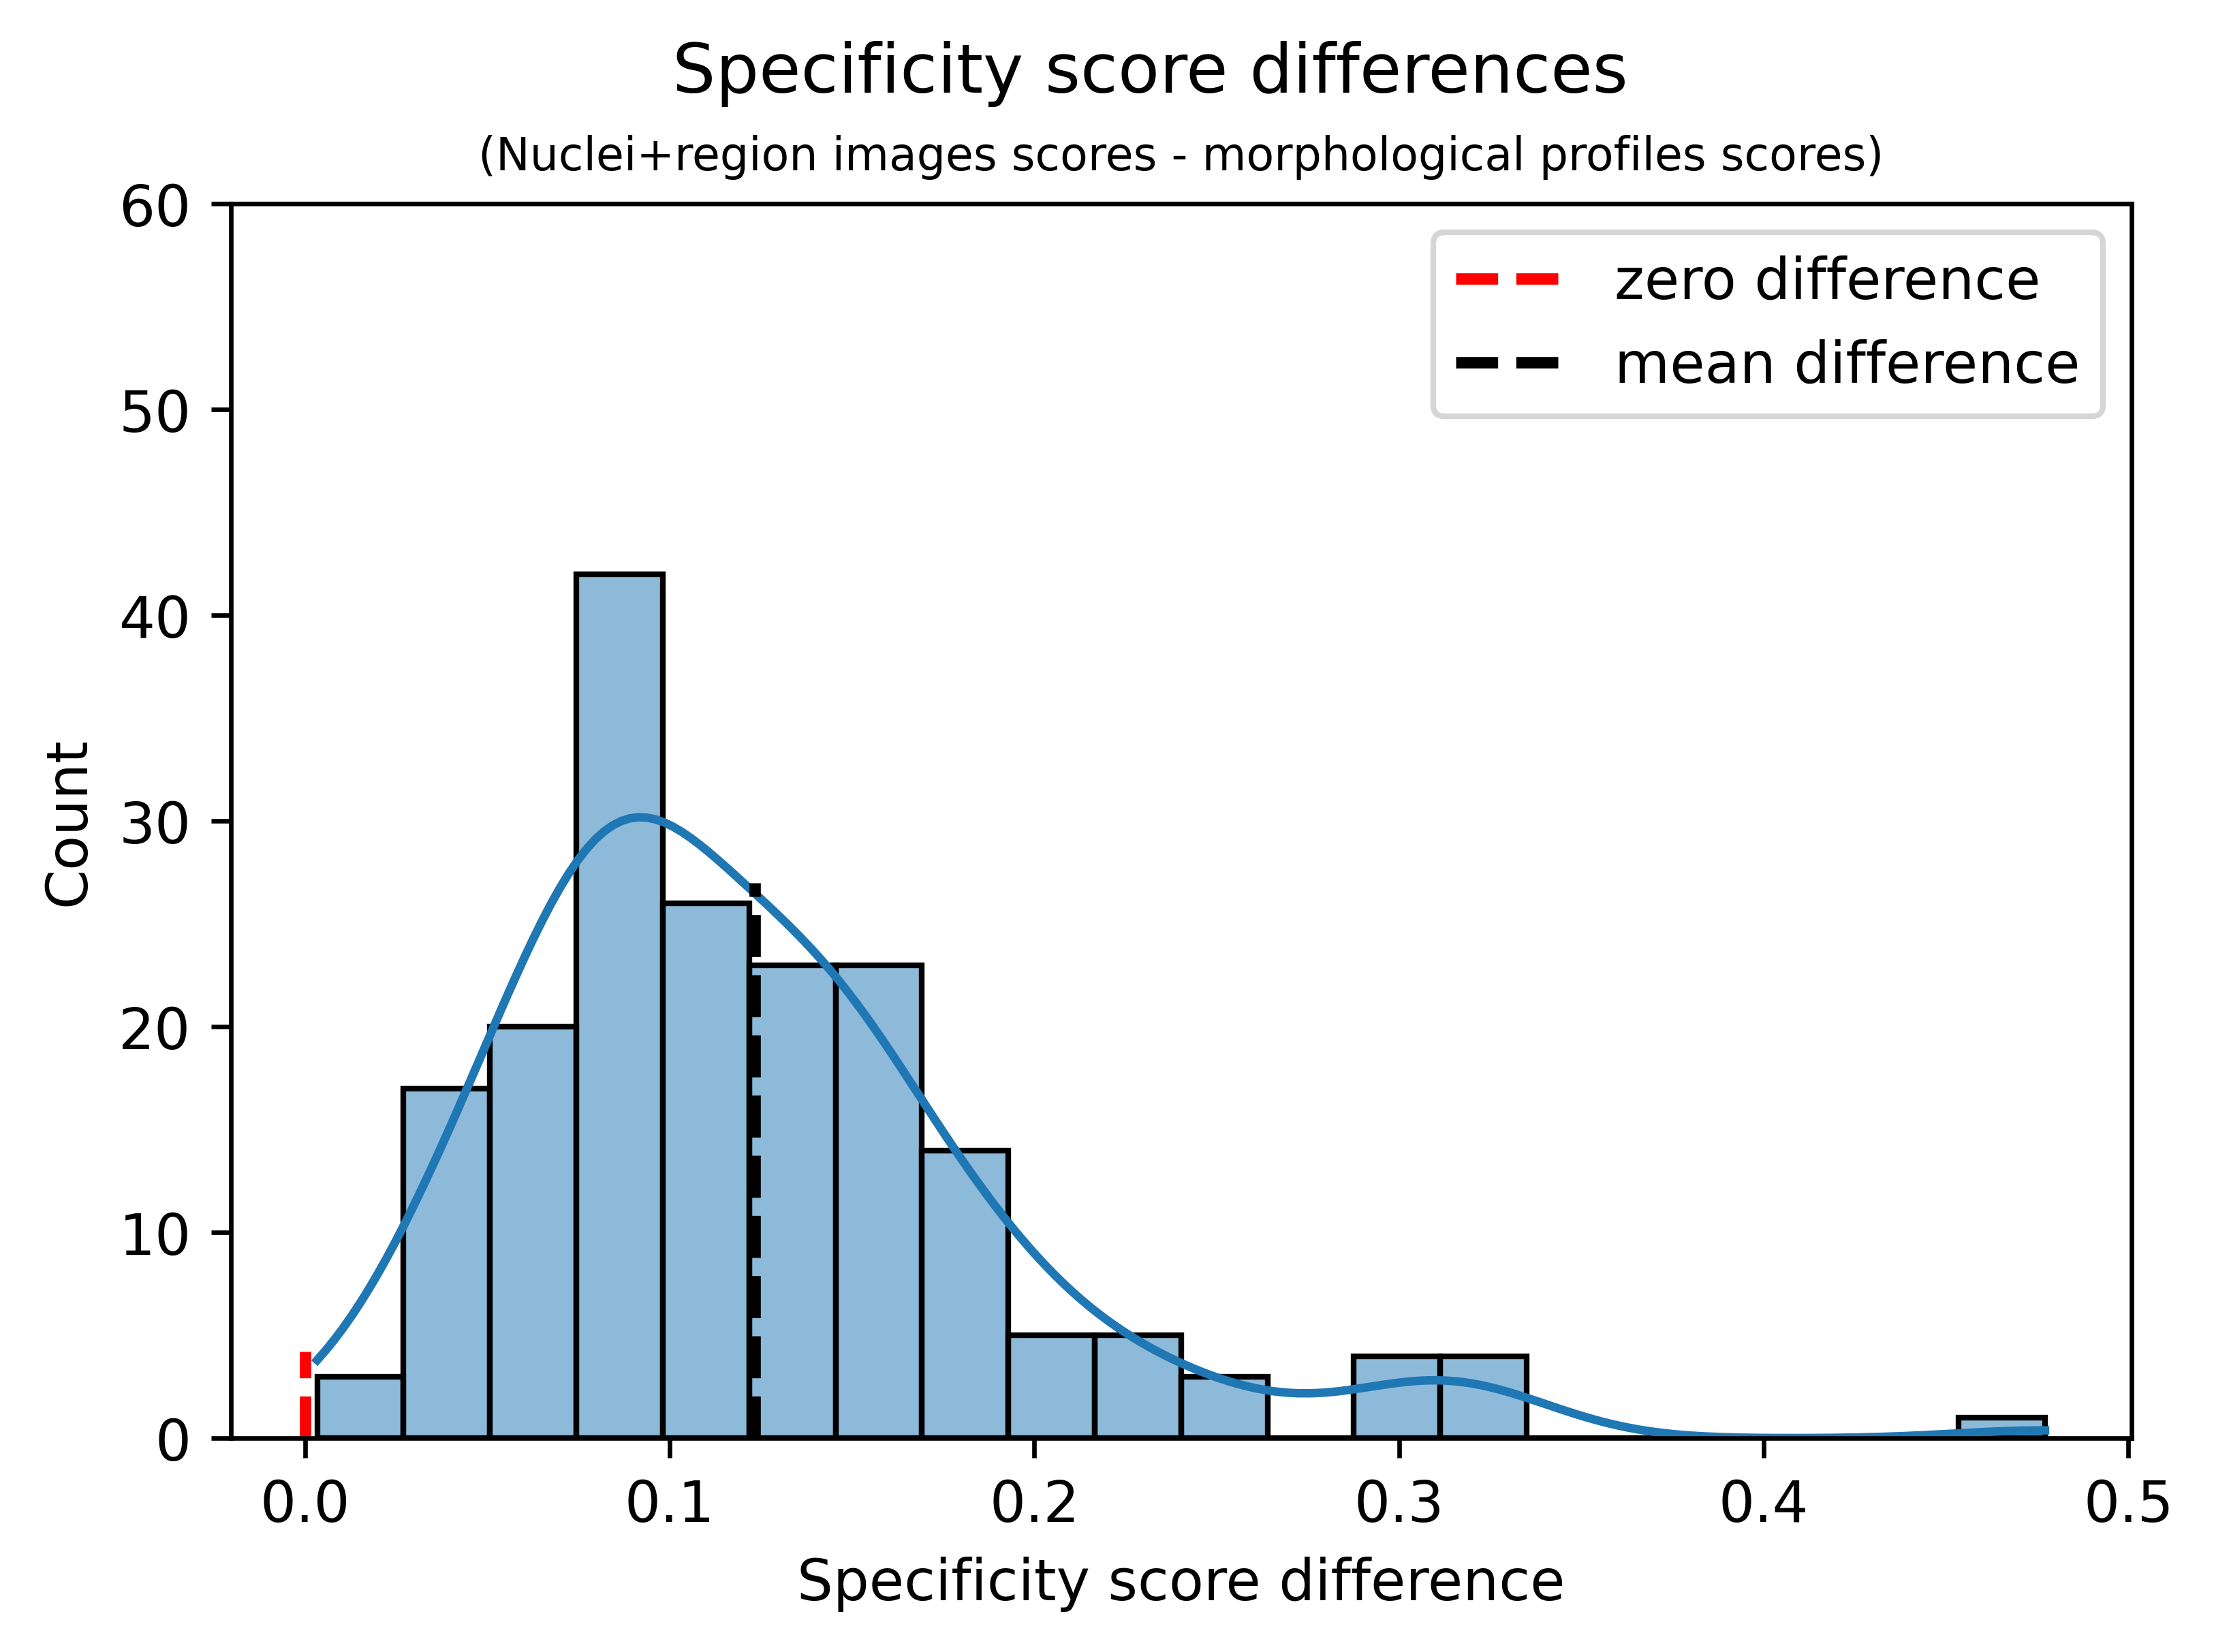

In [26]:
print("t-test for zero-mean", ttest_1samp(np.array(multi_minus_morph_results.test_bacc), popmean=0, alternative="greater"))

fig, ax = plt.subplots(figsize=[6, 4])
ax = sns.histplot(
    data=multi_minus_morph_results, x="test_bacc", kde=True, bins=20, alpha=0.5
)
# ax.set_xlim([-0.3, 0.3])
ax.axvline(x=0, linestyle="--", linewidth=2, color="red", ymax=0.07, label="zero difference")
ax.axvline(
    x=multi_minus_morph_results.test_bacc.mean(),
    linestyle="--",
    linewidth=2,
    color="k",
    ymax=0.45,
    label="mean difference"
)
ax.legend()
ax.set_ylim([0, 60])
ax.set_xlabel("Specificity score difference")
#plt.xticks(np.arange( 0.55, 0.05))
plt.suptitle("Specificity score differences")
plt.title("(Nuclei+region images scores - morphological profiles scores)", fontsize=8)
plt.show()


 ---
 
 
 #### 2.2.3. Comparison of all screens.
 
 Finally, we will jointly compare the distributions of the individual screens.

In [27]:
avg_morph_results["input"] = "Morphological\nprofiles"
avg_nuclei_results["input"] = "Nuclei\nimages"
avg_multi_results["input"] = "Nuclei + region\nimages"

all_avg_results = avg_morph_results.append(avg_nuclei_results).append(avg_multi_results)

<ipython-input-27-e9dcff468557>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_avg_results = avg_morph_results.append(avg_nuclei_results).append(avg_multi_results)
<ipython-input-27-e9dcff468557>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_avg_results = avg_morph_results.append(avg_nuclei_results).append(avg_multi_results)


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Using zero_method  wilcox
Morphological
profiles v.s. Nuclei
images: Wilcoxon test (paired samples) with Bonferroni correction, P_val=6.297e-29 stat=5.270e+02
Using zero_method  wilcox
Nuclei
images v.s. Nuclei + region
images: Wilcoxon test (paired samples) with Bonferroni correction, P_val=2.002e-32 stat=4.000e+00
Using zero_method  wilcox
Morphological
profiles v.s. Nuclei + region
images: Wilcoxon test (paired samples) with Bonferroni correction, P_val=1.879e-32 stat=0.000e+00


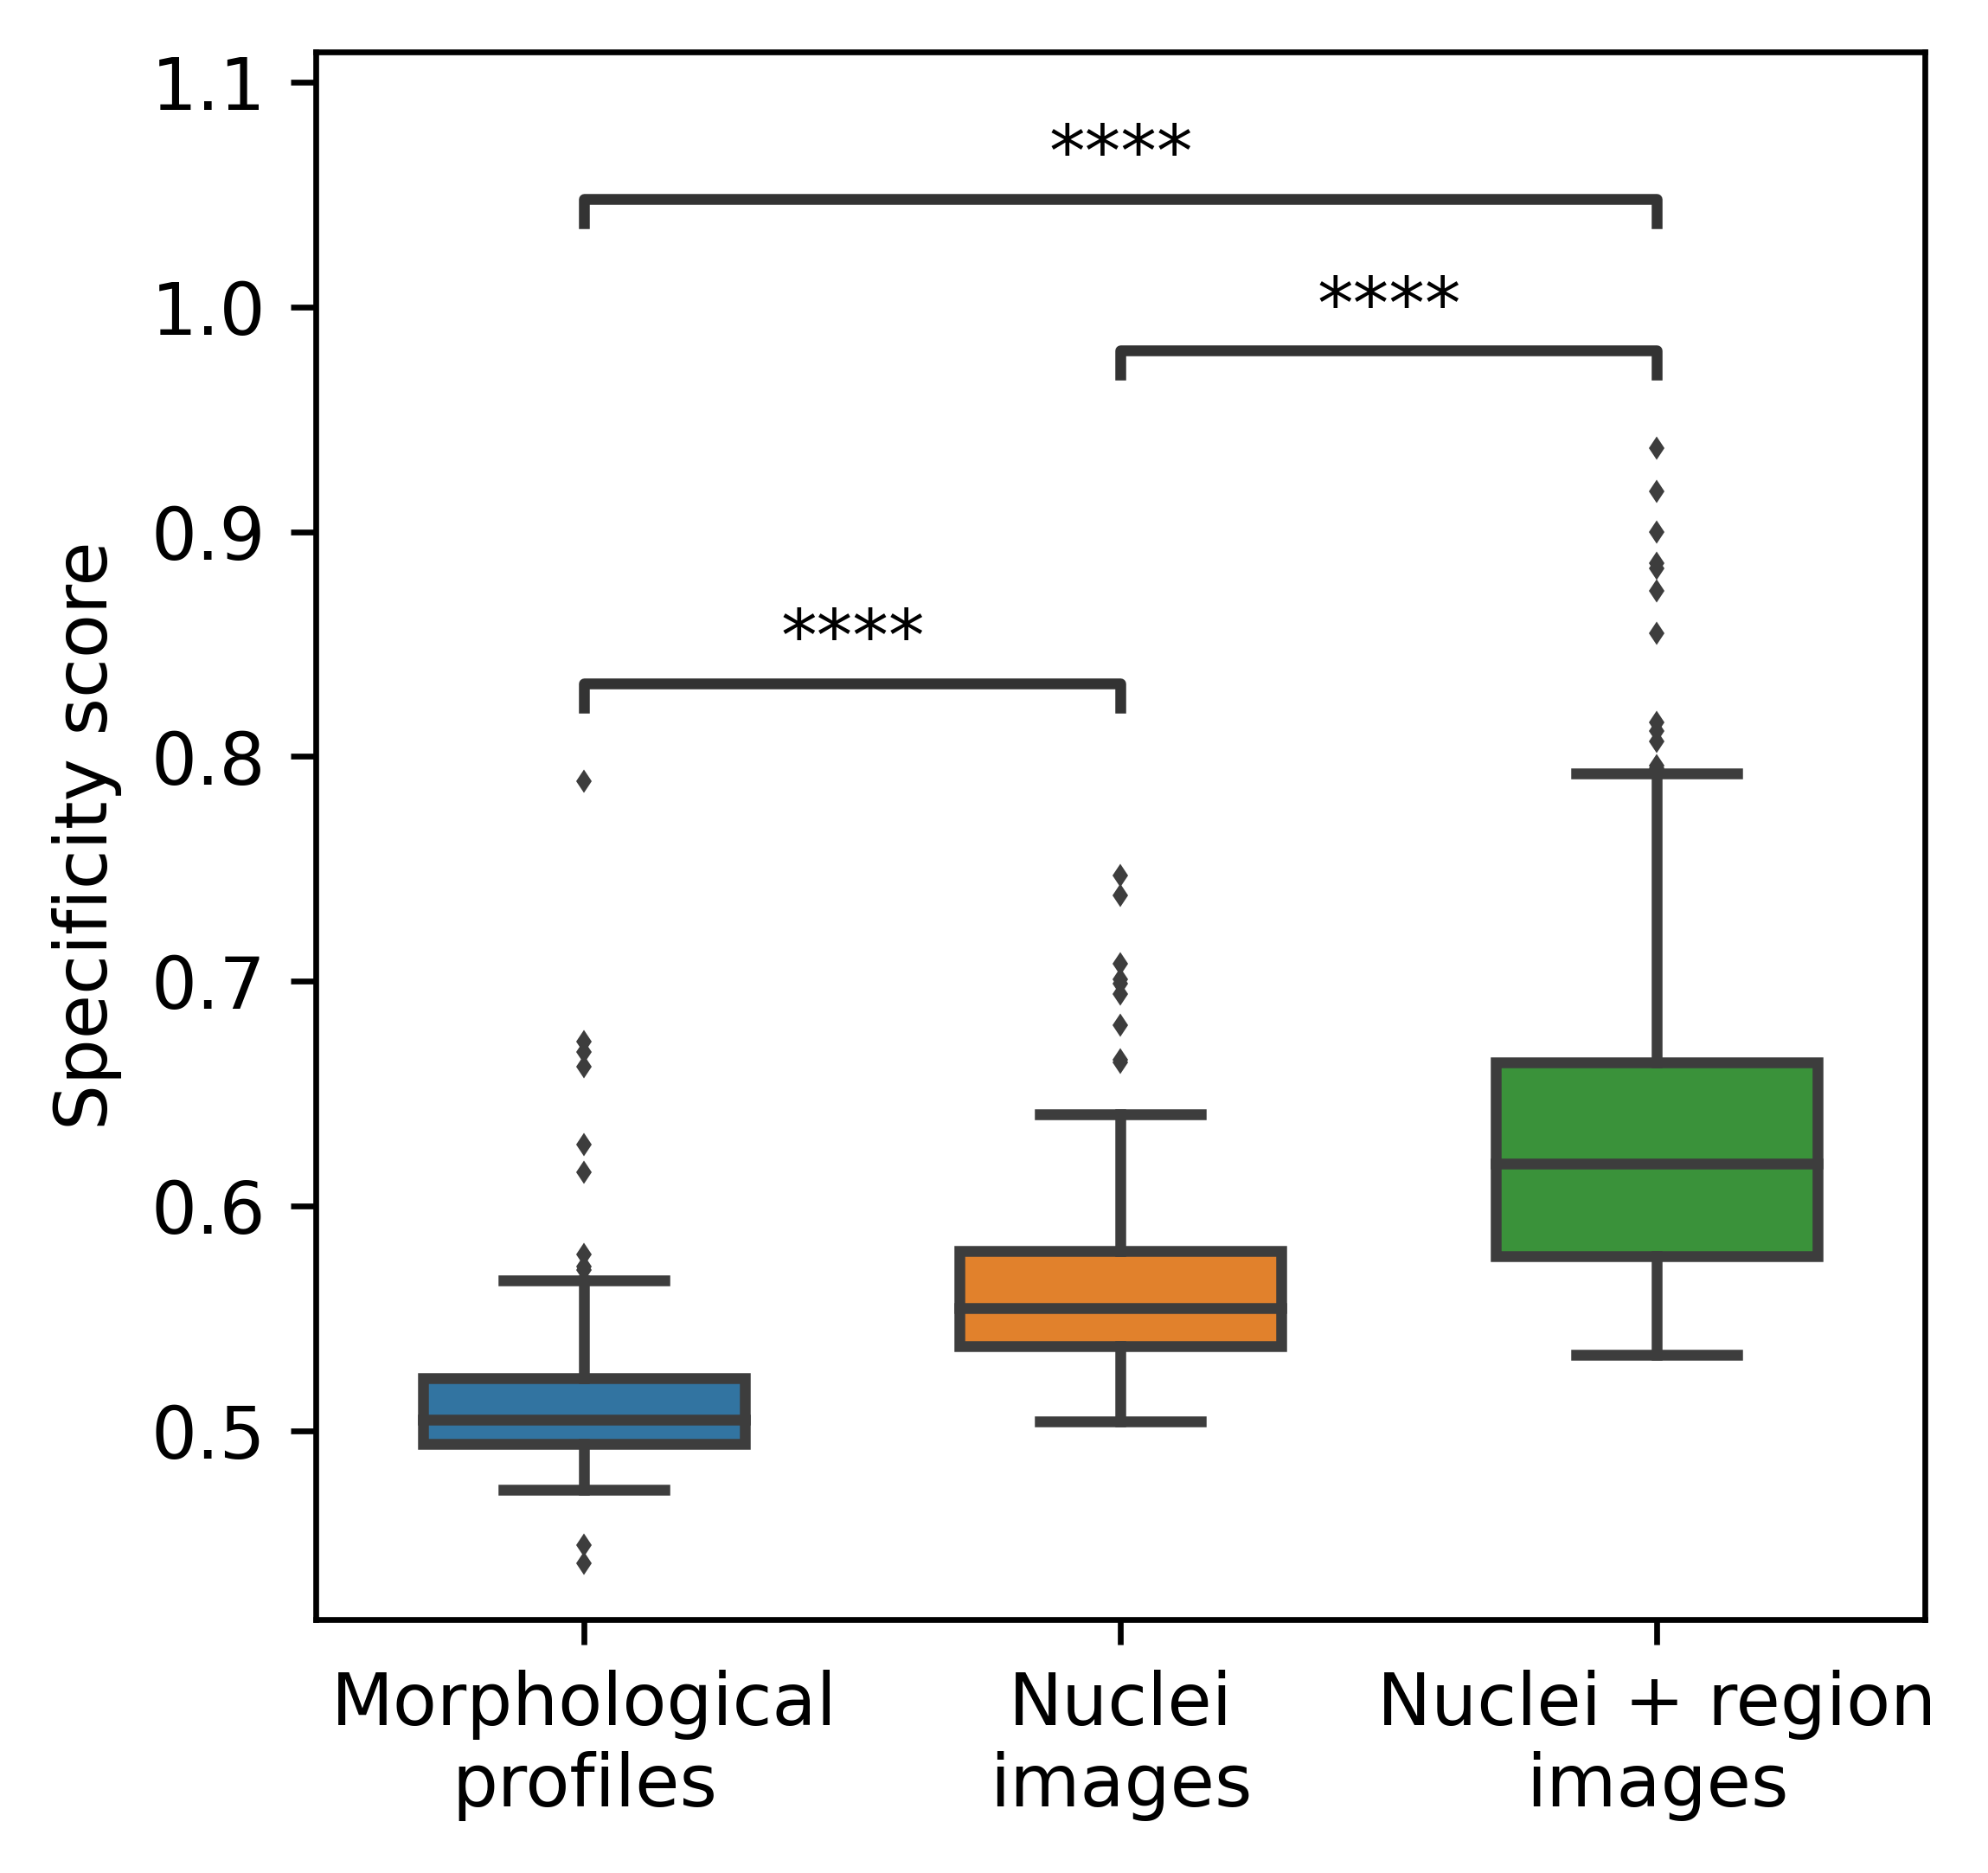

In [28]:
fig, ax = plt.subplots(figsize=[4, 4])
ax = sns.boxplot(
    data=all_avg_results,
    y="test_bacc",
    x="input",
    ax=ax,
    order=["Morphological\nprofiles", "Nuclei\nimages", "Nuclei + region\nimages"],
    width=0.6,
    fliersize=1,
)
ax.set_xlabel("")
ax.set_ylabel("Specificity score")

add_stat_annotation(
    ax,
    data=all_avg_results,
    x="input",
    y="test_bacc",
    box_pairs=[
        ("Morphological\nprofiles", "Nuclei\nimages"),
        ("Morphological\nprofiles", "Nuclei + region\nimages"),
        ("Nuclei\nimages", "Nuclei + region\nimages"),
    ],
    test="Wilcoxon",
    text_format="star",
    loc="inside",
    order=["Morphological\nprofiles", "Nuclei\nimages", "Nuclei + region\nimages"],
)
plt.show()